<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/LSC_Sentiment_Analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LSC_Sentiment_Analysis


In [2]:
import numpy as np
import seaborn as sns

try:
  import json
except:
  %pip install -q json
  import json

try:
  import logging
except:
  %pip install -q logging
  import logging

try:
  import sys
except:
  %pip install -q sys
  import sys

try:
  import os
except:
  %pip install -q os
  import os

try:
  import pandas as pd
except:
  %pip install -q pandas
  import pandas as pd

try:
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary
except:
  %pip install -q torch
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary

try:
  from sklearn.model_selection import train_test_split
except:
  %pip install -q sklearn
  from sklearn.model_selection import train_test_split

try:
  import transformers
  from transformers import BertTokenizer, BertModel, BertConfig
except:
  %pip install -q transformers
  import transformers
from transformers import BertTokenizer, BertModel, BertConfig

from evaluation_bert import test_bert
from data.datasets import dataset
from main import load_json
from evaluation import test_statistics



# 1. Theorie BERT

Das Acronym BERT steht für "**B**idirectional **E**ncoder **R**epresentations from **T**ransformers" und ist eine Netzwerk-Architektur, die von der Google Tochter DeepMind entwickelt und publiziert wurde. [1]

## 1.1 Modellarchitektur

 Die Architektur ist ein multi-layer bidirektionaler Tranformer-Encoder basierend auf der implementation von Vaswani et al. [2]. Die Architektur eines Tranformers wurde in dem Kurzvortrag "Attention is all you need" in der Vorlesung vorgestellt und soll daher hier, abgesehen von dem für uns relenvanten Encoder-Block, nicht weiter ausgeführt werden. Der Encoder ist ein Block, der aus einem multi-head Self-Attention-Layer und einem simplen Feed Forward Netzwerk besteht. Außerdem wird nach jedem Layer normalisiert und die Inputs des Layers aufaddiert, wie bei einer Skip-Connection eines Residual-Layer. Diese Architekur ist
 unten in dem Origialbild aus dem Paper visualisiert.

# 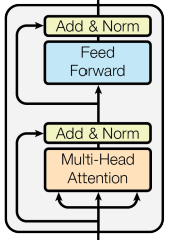


 Der Self-Attention-Mechanismus ist eine wichtige Entwicklung im Bereich des Natural Language Processing, die durch den Einsatz in der Transformer Architektur aus dem Paper "Attention is all you need" hohe Aufmerksamkeit in der Machine Learning-Community erlangt hat. In einem Self-Attention Layer werden aus der tokenisierten und embeddeten Inputsequenz die 'Values' der Tokens gewichtet durch das Produkt aus 'Queries' und 'Keys' der Tokens addiert. Die 'Values', 'Queries' und 'Keys' sind Matrizten, die über gelernte Gewichtsmatrizen aus der Inputsequenz berechnet werden. [2] Die Grundidee dabei ist, dass die 'Keys' und die 'Queries' die Wichtigkeit verschiedener Tokens in der Sequenz erkennen und die 'Values' jeweils einen Wert der dort stehenden Tokens repräsentieren.

Die Innovation, die Google mit dem BERT-Modell, geschaffen hat, liegt dabei im Pre-Training des Modells. Die klassischen Tranformer werden durch die Prediktion des Folgewortes einer Inputsequenz trainiert. Dem entsprechend sind zur Berechnung des 'Values' des zu predizierenden nächsten Wortes die 'Values' der Folgeworte maskiert. Man spricht dabei von einer left-to-right-Architektur, weil der Algorithmus wie ein Mensch den Text von links nach rechts 'ließt'. Das BERT-Modell setzt im Gegensatz dazu auf einen bidirektionalen Ansatz. Das heißt, dass die nachfolgenden Wörter zur Berechnung der 'Values' nicht maskiert werden. Beim Training werden daher nur einzelne zufällige Wörte im Text maskiert, die dann prediziert werden. Als zweite Trainingsaufgabe werden dem Netzwerk zwei Sätze präsentiert und das Netzwerk muss entscheiden, ob der zweite Satz auf den ersten Satz folgen kann oder ob die beiden Sätze hintereinander keinen Sinn ergeben. Aufgrund dieses Trainingsansatzes ist das Netzwerk gut geeignet zur Extraktion des Kontextes bzw. des Iahaltes eines Textes, jedoch weniger, um künstliche Texte zu generieren. [1]

Da Sentiment Analyse eine Art der Klassifikation des Inhaltes von Texten ist, haben wir uns dazu entschieden für diese Projekt ein BERT-Modell als Large Language Model einzusetzen.


# 1.2 Fine-Tuning

Fine-Tuning bezeichnet das Anpassen von vortrainierten Modellen auf den eigenen spezifischen Anwendungsfalls. In diesem Fall ist der BERT Modell auf allgemeinen Texten und mit der oben beschriebenen Methodik vortrainiert. Um das Modell auf unsere Sentiment Analyse anwenden zu können, muss zum einen die Architektur entsprechen angepasst werden und die Parameter müssen in der spezifischen Domäne nachtrainiert werden.

Laut den Authoren von DeepMind ist zur Anpassung der Architektur nichts weiter nötig, als das anhängen eines Aufgabenspezifischen Layers. [1]

# 2. Vorgehen bei Experimenten

Um eine Vielzahl an verschiedenen Ansätzen ausprobieren zu können, haben wir eine Programmstruktur aufgebaut, die es uns erlaubt hat, trotz einer Vielzahl von Versuchen das Vorgehen zu standardisieren. Da dies unser erstes umfangreiches Projekt zu diesem Thema ist, hat das Schaffen dieser Struktur alleine relativ viel Zeit in Anspruch genommen und ist für uns neben den Ergebnissen der Experimente ein wichtiges Ergebnis dieses Projektes. Daher soll dies in diesem Abschnitt ebenfalls erläutert werden.

## 2.1 Training Neuronaler Netze

Wie in der Vorlesung behandelt, wird beim Trainieren von Neuronalen Netzen über mehrere Epochen der gesamte Trainingsdatensatz durch das Modell propagiert, der Fehler über eine Loss-Funktion berechnet und auf Basis dieses Losses die Parameter des Netzes über die Backpropagation optimiert. Bei großen Daten ist es üblich, dabei pro Epoch den Datensatz zufällig in sogenannte Batches zu unterteilen. Jede Batch wird dann einzeln vorwärts und rückwerts propagiert. Der Grund für dieses Vorgehen ist, dass wegen Hardware-Limitationen oft nicht der gesamte Datensatz auf einmal verarbeitet werden kann. Wir haben dieses Vorgehen in einer Klasse *nettrainer* realisiert, der alle relevanten Trainingsparameter übergeben werden, wie zum Beispiel Batchsize, das zu trainierende Modell oder das Hardware-Device auf dem trainiert werden soll.

Nach jeder Epoche wird außerdem das Validation-Set einmal durch das Netzwerk propagiert und der Loss sowie die Accuracy berechnet. Die Loss-Funktion wird ebenfalls dem *nettrainer* übergeben. Den Validation-Loss und den Trainings-Loss zu beobachten ist wichtig, um Overfitting im Training zu erkennen. Sinkt der Trainings-Loss im Laufe der Epochen, während der Validation-Loss aber steigt, ist dies ein klares Zeichen für Overfitting. Das Modell funktioniert dann auf den Trainingsdaten besser als auf ungesehenen Daten.

## 2.2 Handhabung der Daten im Training

Zur Implementierung des Trainings haben wir überwiegend die vordefinierten Klassen von Pytorch genutzt, zur Datenhandhabung im speziellen die Dataset- und die Dataloader-Klasse. Die Datalaoder-Klasse ermöglich das ziehen von Batches aus einem Dataset, dass der Klasse übergeben wird. Die Dataset-Klasse ermöglicht den Zugriff auf die Samples (bei Torch: 'Items') über einen Index. Wir haben bei der Implementierung der Dataset-Superklasse außerdem eingebaut, dass bei setzen entprechender Variablen die Inputs des Items tokenisiert oder/und die Target-Labels onehot-encoded werden. Dies ermöglicht es, mit der selben Klasse verschiedene Datensätze (wie bei uns Movie-Reviews und Twitter) für verschiedene Netzwerk-Architekturen zu verarbeiten.

Wie bereits im Notebook zur Voranalyse der Daten beschrieben, sind wir bei den ersten Versuchen, das Netz auf der CPU unserer Rechner zu trainieren, an die Grenzen unserer Hardware gestoßen. Speziell hat der RAM nicht ausgereicht, um das Training zu starten. Daher haben wir auf 6 getrennten Datensätzen trainiert. Um dies zu zu ermöglichen wird erst beim starten des Trainings im *Nettrainer* der Datensatz mit der Dataset- und Dataloader-Klasse geladen. Optional kann man dem *Nettrainer* über eine Variable den gesamten Trainingsdatensatz zu Beginn des Trainings oder rundum einen der 6 Datensätze pro Epoche laden lassen.

## 2.3 Training-Hyperparameter-Management

Bei beim Training von Neuronalen Netzen gibt es eine Vielzahl von Hyperparametern, die man variieren kann, um ein möglichst gutes Ergebnis zu erzielen. Diese Parameter umfassen Parameter für das Training, von denen oben bereits einige genannt wurde, aber auch Parameter, wie die Datenaufbereitet werden und wie das Netzgestaltet ist. Da für uns ein Lernziel dieses Projektes war, ein Gefühl dafür zu bekommen, wie sich welche Parameter auf das Trainingsverhalten auswirken, haben wir das Hyperparameter-Tuning nicht automatisiert, sondern manuell gemacht. Um trotzdem den Überblick zu behalten defurfte es einen System zur Steuerung dieser Parameter. Dazu haben wir eine JSON-Datei angelegt, in der alle einstellbaren Parameter hinterlegt werden und die dann in unserer main() eingelesen wird und aus der die Parameter an entsprechender Stelle im Programm ablauf eingelesen werden. Unten ist exemplarisch eine solche JSON-Datei abgebildet.

In [ ]:
"""
 {
    "name": "PPBERT_2Res_do3_MSE--bs45--adam",
    "model_type": "MLP",
    "model_path": "",
    "data_dir": "dataset_mr_after_first_layer_notOH",
    "batchsize_train": 100,
    "batchsize_val": 200,
    "batchsize_test": 200,
    "epochs": 1500,
    "n_trainsets": 6,
    "start_trainset": -1,
    "freeze_first": false,
    "inflation": 10,
    "patience": 0,
    "validation_size": 0.2,
    "learning_rate": 0.03,
    "momentum": 0.5,
    "gpu": true,
    "seed": 42,
    "translateV_chance": 0.5,
    "channels": 1,
    "criterion": "mse",
    "optimizer": "adam",
    "onehot": false,
    "tokenize": true,
    "max_len": 200
}
"""

'\n {\n    "name": "PPBERT_2Res_do3_MSE--bs45--adam",\n    "model_type": "MLP",\n    "model_path": "",\n    "data_dir": "dataset_mr_after_first_layer_notOH",\n    "batchsize_train": 100,\n    "batchsize_val": 200,\n    "batchsize_test": 200,\n    "epochs": 1500,\n    "n_trainsets": 6,\n    "start_trainset": -1,\n    "freeze_first": false,\n    "inflation": 10,\n    "patience": 0,\n    "validation_size": 0.2,\n    "learning_rate": 0.03,\n    "momentum": 0.5,\n    "gpu": true,\n    "seed": 42,\n    "translateV_chance": 0.5,\n    "channels": 1,\n    "criterion": "mse",\n    "optimizer": "adam",\n    "onehot": false,\n    "tokenize": true,\n    "max_len": 200\n}\n'

## 2.4 Trainingsmonitoring

Neben dem Management der Parameter ist es bei der manuellen Arbeit mit Neuronalen Netzen auch wichtig, die Trainingsergebnisse systematisch zu dokumentieren. Dies haben wir mit Hilfe von Tensorbaord gemacht. Tensorboard ist ein Modul von Tensorflow, das es ermöglicht verschiedene Werte aus einem Trainingsablauf zu tracken und anschließend in einer benutzerfreundlichen Web-Anwendung darzustellen. Dazu haben wir ein Logger-Klasse geschrieben, die mit dem Summary-Writer von Pytorch arbeitet. Wir haben mit dem Logger folgende Parameter getrackt:

*   Parameter-Setting aus JSON-Datei
*   Startzeitpunkt
*   Endzeitpunkt
*   Trainingsdauer
*   Grund für Trainingsende
*   Trainings- und Validation-Loss pro Epoche
*   Accuracy pro Epoche
*   Aufbau des genutzten Netzes



# 3. Trainingsergebnisse

## 3.1. Erster Versuch: Training gesamtes Modell

Bei den ersten Druchläufen mit dem Movie-Review-Dataset haben wir verschiedene Netzwerkarchitekturen als Klassifizier an den BERT-Layer angehängt und alle Parameter des Netzes inklusive der des vortrainierten BERT-Layers optimiert. Zusammenfassend haben wir dabei die Erkenntnis erlangt, dass der Datensatz wahrscheinlich zu klein ist für so ein tiefes Netzwerk, da alle Versuche der Regularisierung fehlgeschlagen sind und es immer zum Overfitting gekommen ist. Im Folgenden ist ein Screenshot aus dem Tensorbaord zu sehen mit allen Trainingsversuchen in diesem Stadium. Weiter unten sind die verschiedenen Regularisierungsversuche detailliert erklärt mit einzelnen Grafiken zu den resultierenden Trainingsverläufen.

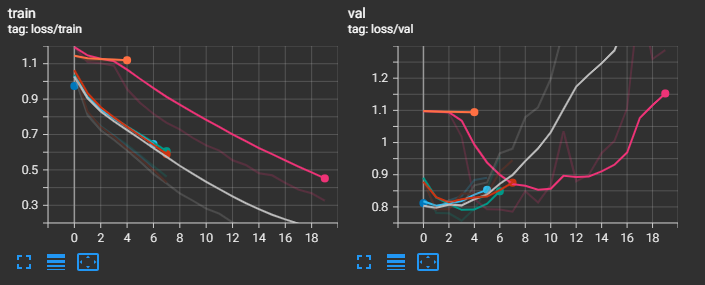

Man sieht in dieser Zusammenfassung bereits, dass bei allen Versuchen der Trainings-Loss sinkt, während der Validation-Loss nach kurzer Verbesserung schnell wieder ansteigt.

### 3.1.1 Simple Fully Connected Layer

Der erste Versuch war ein einfacher fully-connected Layer und einem Dropout-Layer mit einer Dropout-Quote von 0.3. Dropout ist einer Regularisierungstechnik, bei der zufällig bei jedem Forward-Pass jeweils eine bestimmt Anzahl an Knoten komplett ausgeschaltet wird, unabhängig davon, ob diese durch vorherige Layer aktiviert wurden oder nicht. Dies erschwert es dem Netz Inhalte auswendig zu lernen, weil zufällig auch Knoten, die genau einen sprzifischen Inhalt repräsentieren wegfallen können [3]. Der Fully Connected Layer nimmt als Input die 768 Knoten, die der BERT-Layer als Output generiert und erzeugt aus diesen wiederum 3 Outputs, die jeweils einer der Klassen -1 bis 1 zugeordnet sind. Entsprechend haben wir hier als Loss-Funktion den Softmax Crossentropy-Loss genutzt.

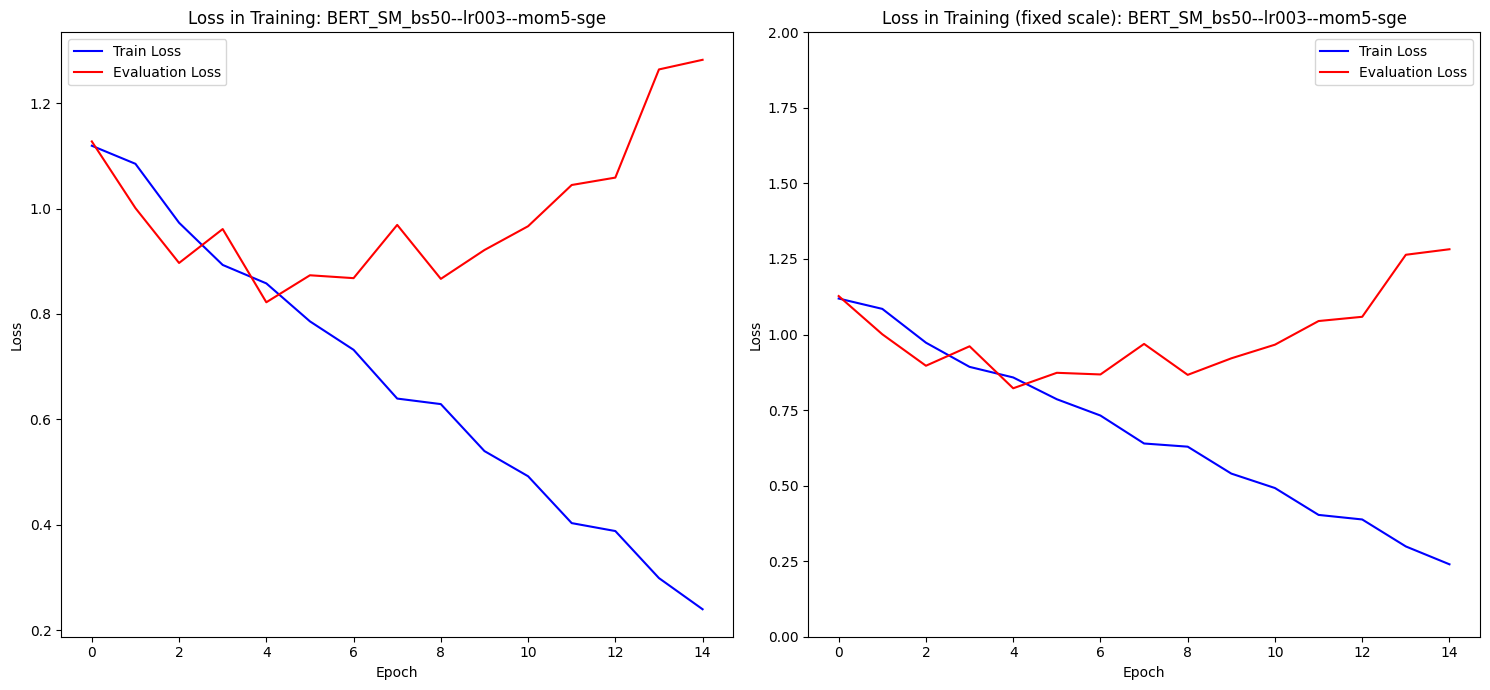

### 3.1.2 Zwei Fully Connected Layer

Als nächstes haben wir eine Klassifizierung mit 2 Fully Conntected Layern ausprobiert, den ersten mit 768, den zweiten mit 200 Input-Knoten. Außerdem haben wir vor beiden Layern wieder einen Dropout-Layer mit einer Quote von 0.3 eingebaut. Durch die Verdoppelung der Anzahl der Dropout-Layer ergebt sich nur noch eine Durchlässigkeit von (1-0.3)^2 = 0.36, was eine Dropout-Quote von 0.64 ist. Da wir keine nicht-Linearität hinzugefügt haben, ist trotz des extra Layers keine erhöhte Komplexität abbildbar.

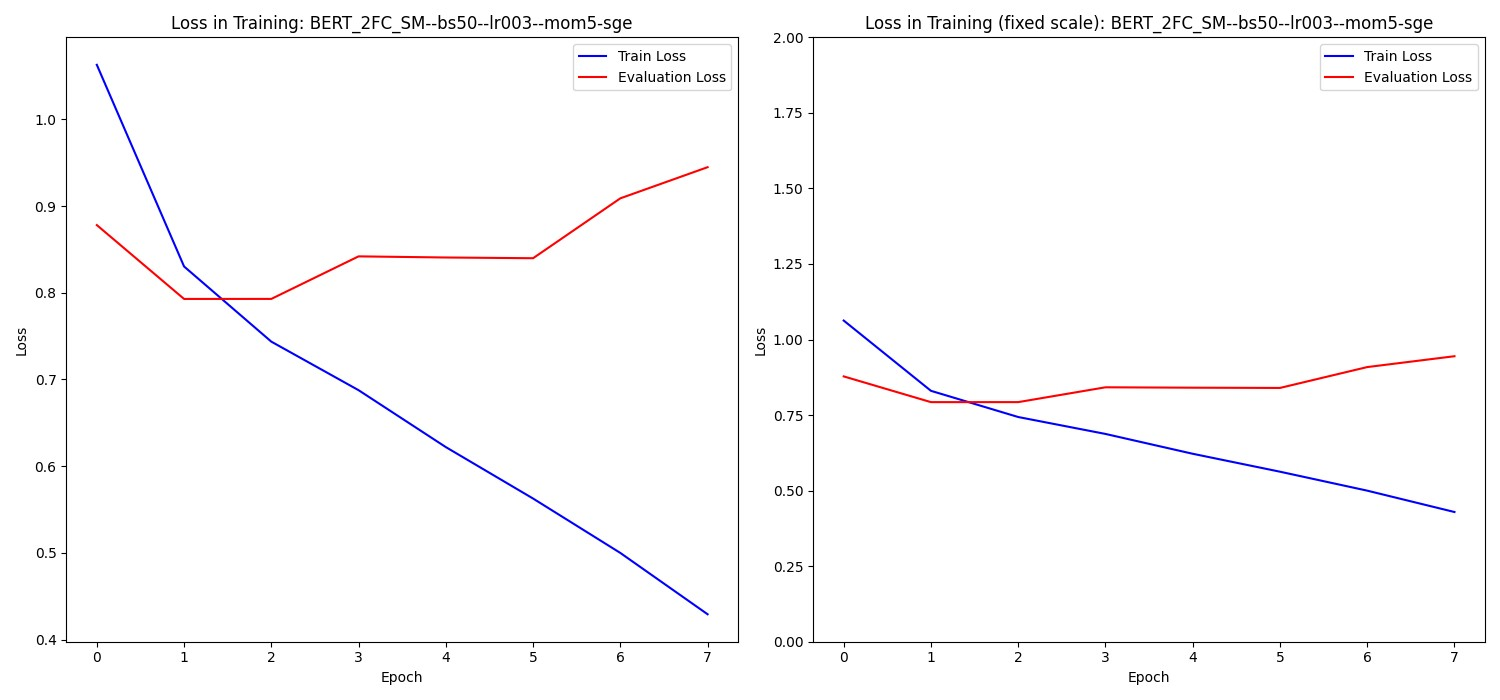

### 3.1.3 Erhöhung Dropout-Quote

In den folgenden beiden Versuchen haben wir die Dropout-Quote in beiden Dropout-Layern auf 0.5, 0.7 und 0.9 erhöht, ohne, dass dieses Overfitting verhindert hätte.

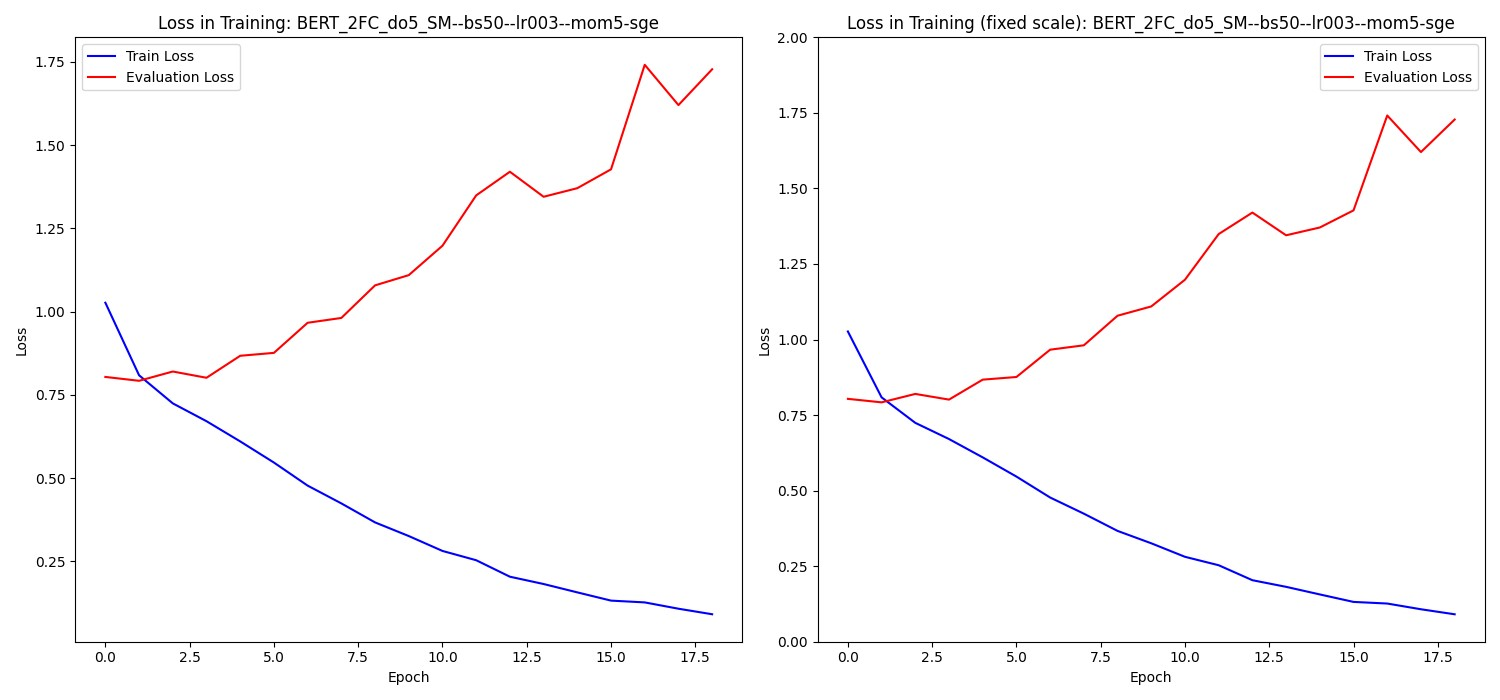

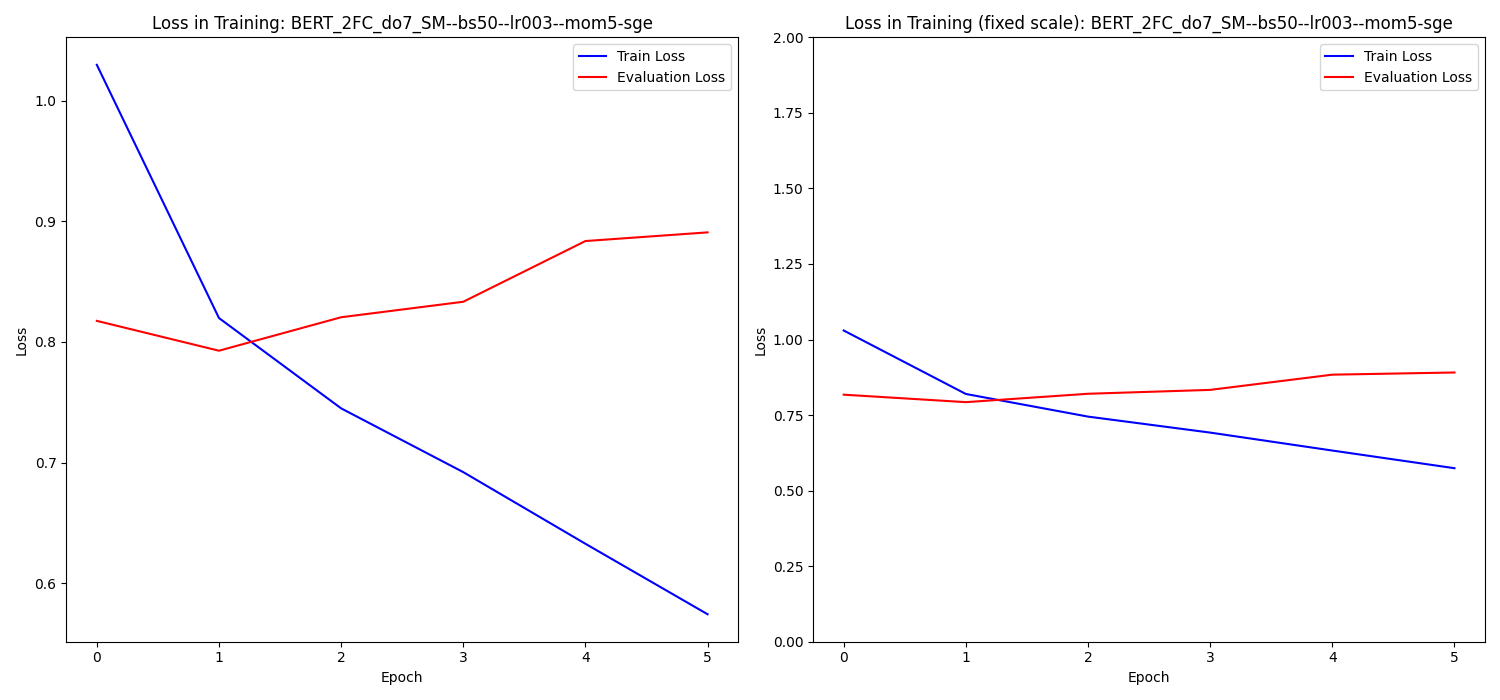

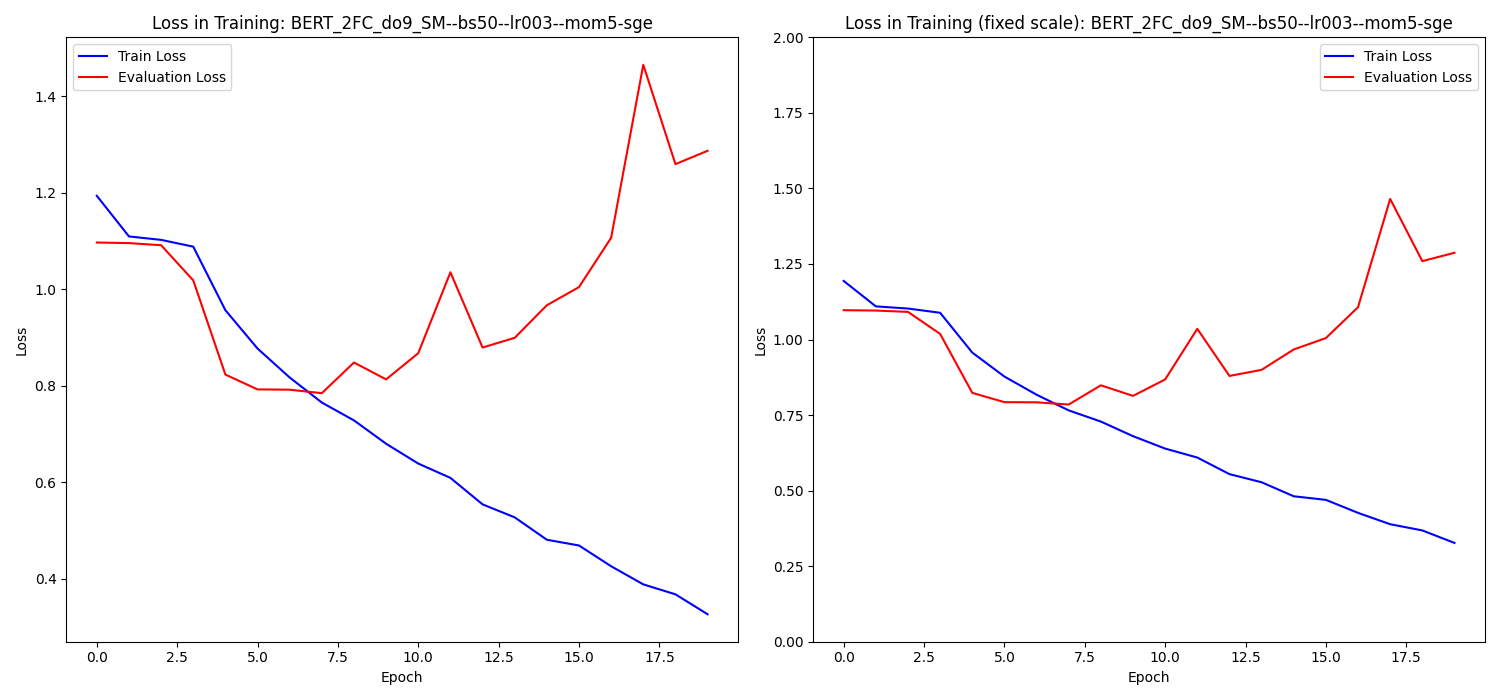

### 3.1.4 Batch-Normalisierung

Batchnormalisierung ist eine Methode zur Generalisierung, bei der in einem Zwischenlayer die Aktivierungen pro Knoten innerhalb einer Batch mit Hilfe von Z-Scaling normalisiert werden. Beim Z-Scaling werden Werte eines Features so transformiert, dass die Werte den Abstand zu ihrem Mittelwert abbilden, wobei eine Einheit einer Standardabwichung entspricht. Man geht hier also von einer Standardnormalverteilung der Feature aus. Hinzu kommen bei der Anwendung von Z-Scaling zur Batch-Normalisierung, dass zwei lernbare Parameter delta und beta, die die Verteilung strecken bzw. stauchen oder und verschieben und somit die Normalisierung an die echte Verteilung anpassen können, da diese nicht immer einer Normalvertielung entspricht. [4]




### 3.1.5 Residual Layer

Zuletzt haben wir einen Residual Layer ausprobiert. Bei einem Residual Layer werden die Inputs, die in einen oder mehrere Layerschichten übergeben werden, nach diesen Schichten auf den Output der Layer aufaddiert. Dadurch lernt der Layer nur die Abweichung von den Inputs und es fällt ihm einfacher, die Identität der Inputs zu lernen. Allerdings führt dies eher dazu, dass die tiefen Schichten besser lernen können, weil die Gradienten besser durch die Residual-Layer propagiert werden können. Von daher ist das Ergebnis, dass es auch hier zu einem Overfitting gekommen ist, nicht überraschen. [5]

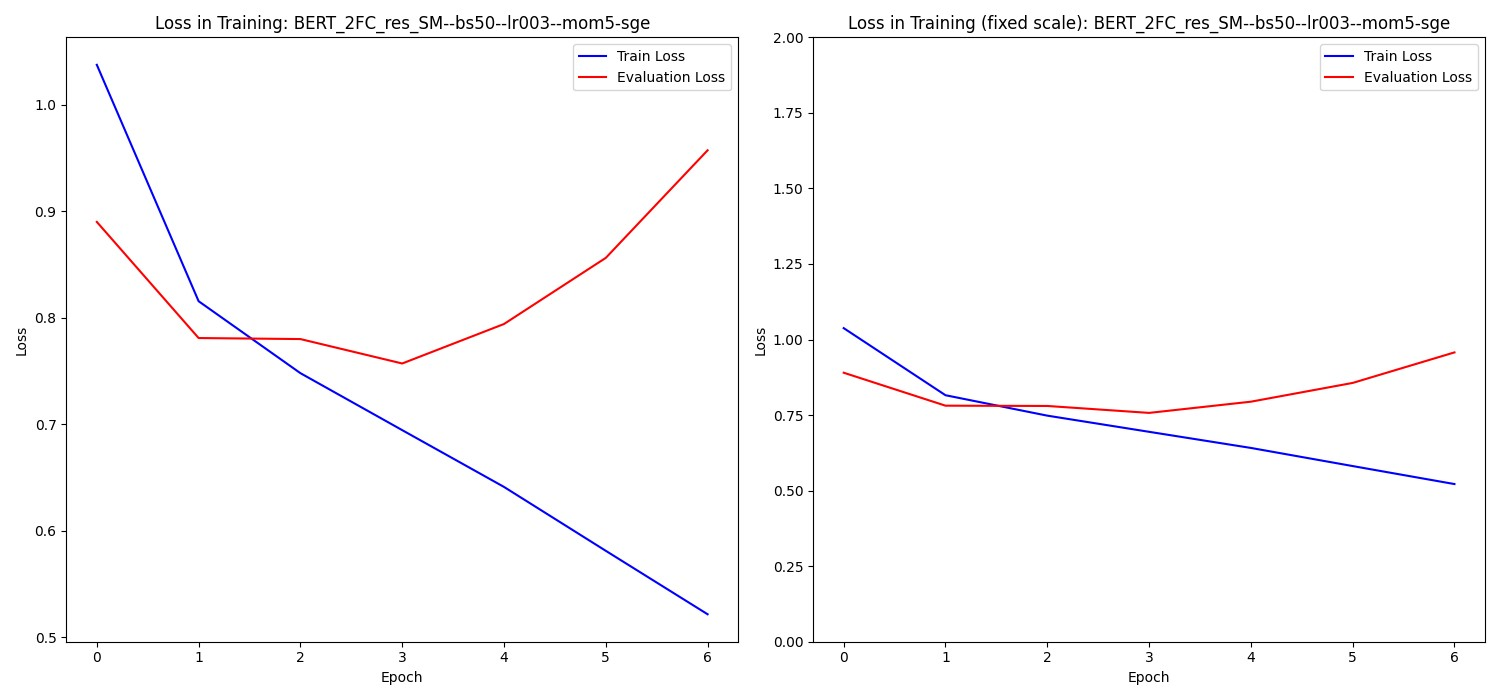

## 3.2 Trainings-Hyperparameter Tuning

Da alle vorher geschilderten Architekturen zu Overfitting geführt haben, haben wir uns dazu entschieden vorerst das Netz ohne BERT-Layer zu trainieren. Dazu haben wir zu Beginn des Trainings jeweils bei allen Parameter im ersten Layer unseres Modells die Eigenschaft *requires_grad* auf *False* gesetzt. Zunächst aber haben wir, aber mit einem verkürzten Trainingsprozess das optimale Hyperparametersetting für das Training identifiziert. Das vorgehen dabei ist im folgenden Unterabschnitt beschrieben.

Zusammenfassend kann man aber sagen, dass die Einstellungen der Hyperparameter nicht von herausragender Bedeutung waren. In der folgenden Zusammenfassenden Grafik, ebenfalls von Tensorbaord kopiert, sieht man, dass fast alle Versuche zu einem sehr ähnlichen Trainingsverlauf führen.

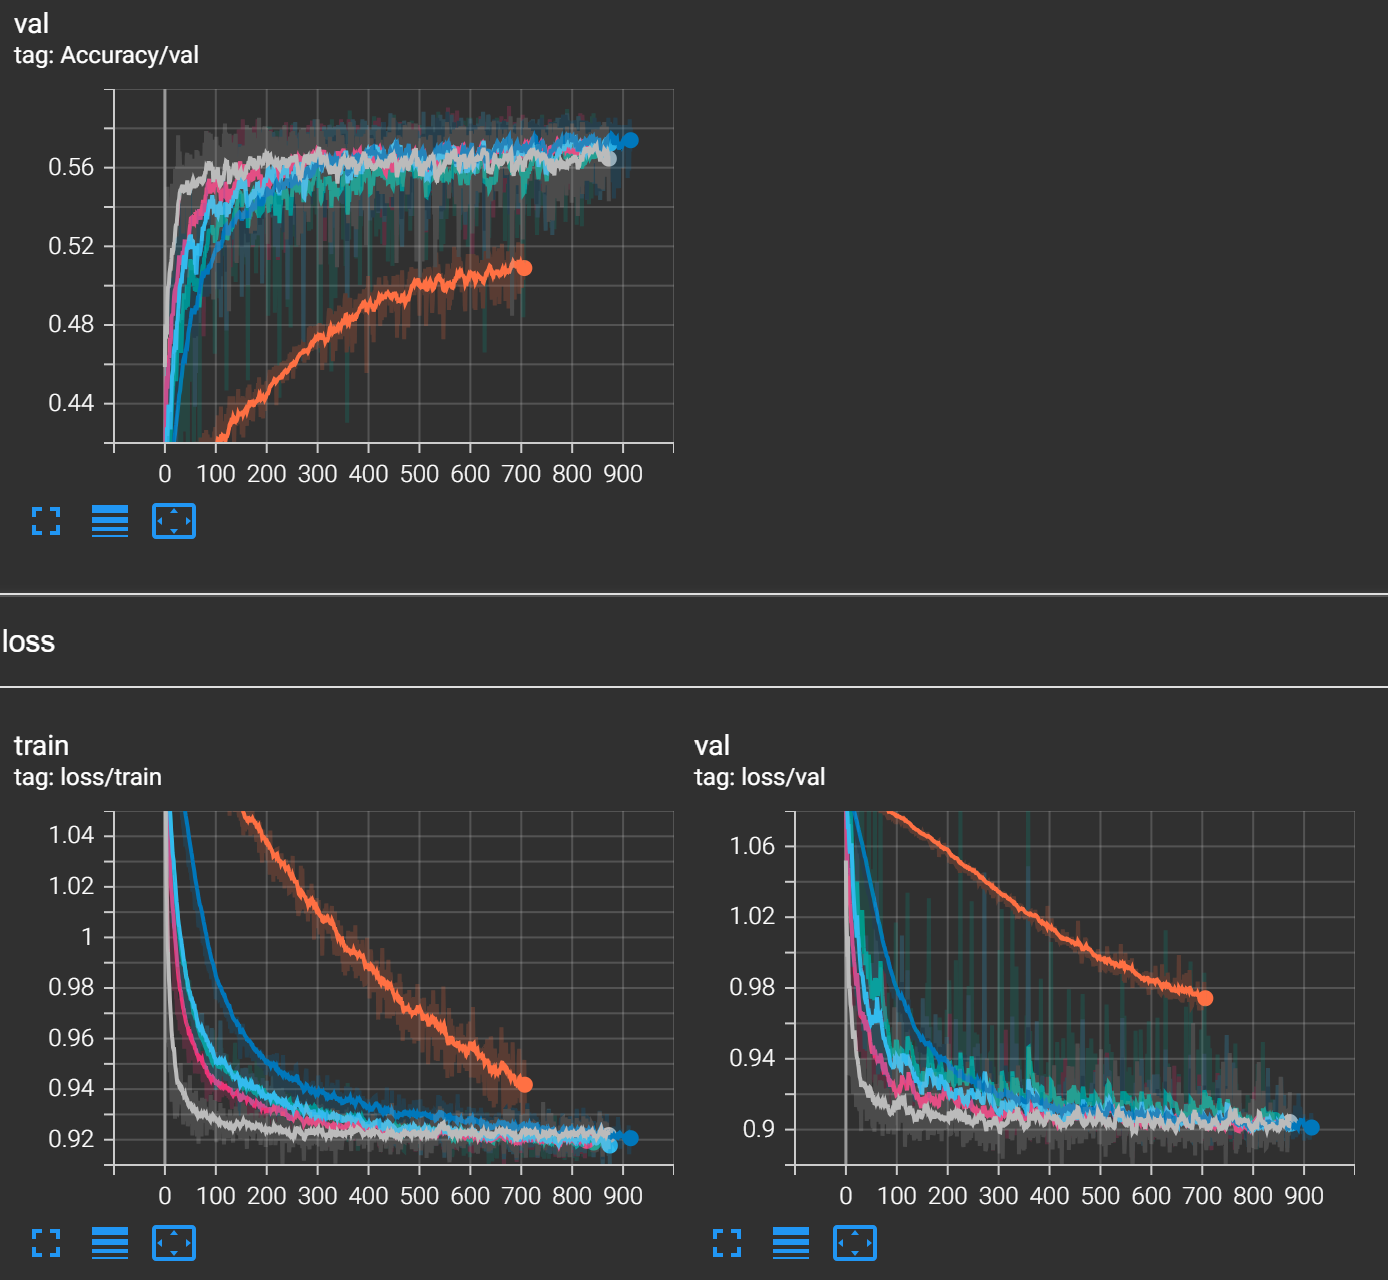

### 3.2.1 Vorgehen beim Hyperparameter Tuning

Um den Trainingsprozess zu beschleuigen, haben wir das Training und das Netz in zwei Teile geteilt. Wir haben zunächst alle Samples in ein Modell gespeist, dass nur den vortrainierten BERT-Layer enthalten hat. Die Outputs haben wir dann als neue Datasets gespeichert. Zum Ausprobieren verschiedener Hyperparameter haben wir dann reine Klassifizierungsarchitekturen auf dem neuerzeugen Datensatz trainiert.

Außerdem hat uns das die Möglichkeit gegeben die Daten einmal zu visualisieren. Unten Visualisieren wird die Daten im Latent-Space, also die Outputs des BERT-Layer. Da der Raum, in dem die Daten liegen, entsprechend der Anzahl der Output-Knoten des BERT-Layer 768 Dimensionen hat, haben wir eine Dimensionsreduktion vorgenommen. Hier haben wir dazu eine PCA genutzt.

In [ ]:
from models.bert_without_mlp import BERTClass_without_mlp
from torch import cuda
from data.datasets import dataset as dataset
from torch.utils.data import DataLoader

In [ ]:
def preprocess_first_layer(path_sets, file_path):
  with torch.no_grad():
    device = 'cuda' if cuda.is_available() else 'cpu'

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BERTClass_without_mlp()
    model.to(device)

    path = os.path.join(path_sets, file_path)
    data = pd.read_csv(path, delimiter=";")
    data = data.reset_index(drop=True)

    dataset_params = {
            'onehot': True,
            'onehot_encoding': [-1, 0, 1],
            'tokenize_bert': True,
            'max_len': 200,
            'tokenizer': tokenizer
        }

    dataset_tmp = dataset(data["Phrase"], data["Sentiment"], **dataset_params)


    # Dataloader initialisieren mit Datasets
    loader = DataLoader(dataset_tmp, batch_size=1)

    outputs_bert = []
    for _, batchdata in enumerate(loader):
      outputs_bert.append(model(batchdata, device).tolist()[0])

    outputs_bert = np.array(outputs_bert)
    dataset_after_first_layer = dataset(outputs_bert,
            data["Sentiment"],
            tokenize_bert=False,
            onehot=True,
            onehot_encoding = [-1, 0, 1],
            second_layer=True)
    dataset_after_first_layer[3]

    return dataset_after_first_layer

In [ ]:
path_sets = "./data/dataset_mr"


for ds in os.listdir(path_sets):
  if ("complete" not in ds):
    dataset_after_first_layer = preprocess_first_layer(path_sets, ds)
    new_path = "data/dataset_mr_after_first_layer/" + ds.split('.')[0] + ".pt"
    torch.save(dataset_after_first_layer, new_path)
    print(ds.split('.')[0] + " saved")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testset saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_1 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_2 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_3 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_4 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_5 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_6 saved


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Validationset saved


In [ ]:
path_sets = "./data/dataset_mr"
train_file = "Trainset_complete.csv"

dataset_after_first_layer = preprocess_first_layer(path_sets, train_file)
new_path = "data/dataset_mr_after_first_layer/" + train_file.split('.')[0] + ".pt"
torch.save(dataset_after_first_layer, new_path)
print(train_file.split('.')[0] + " saved")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainset_complete saved


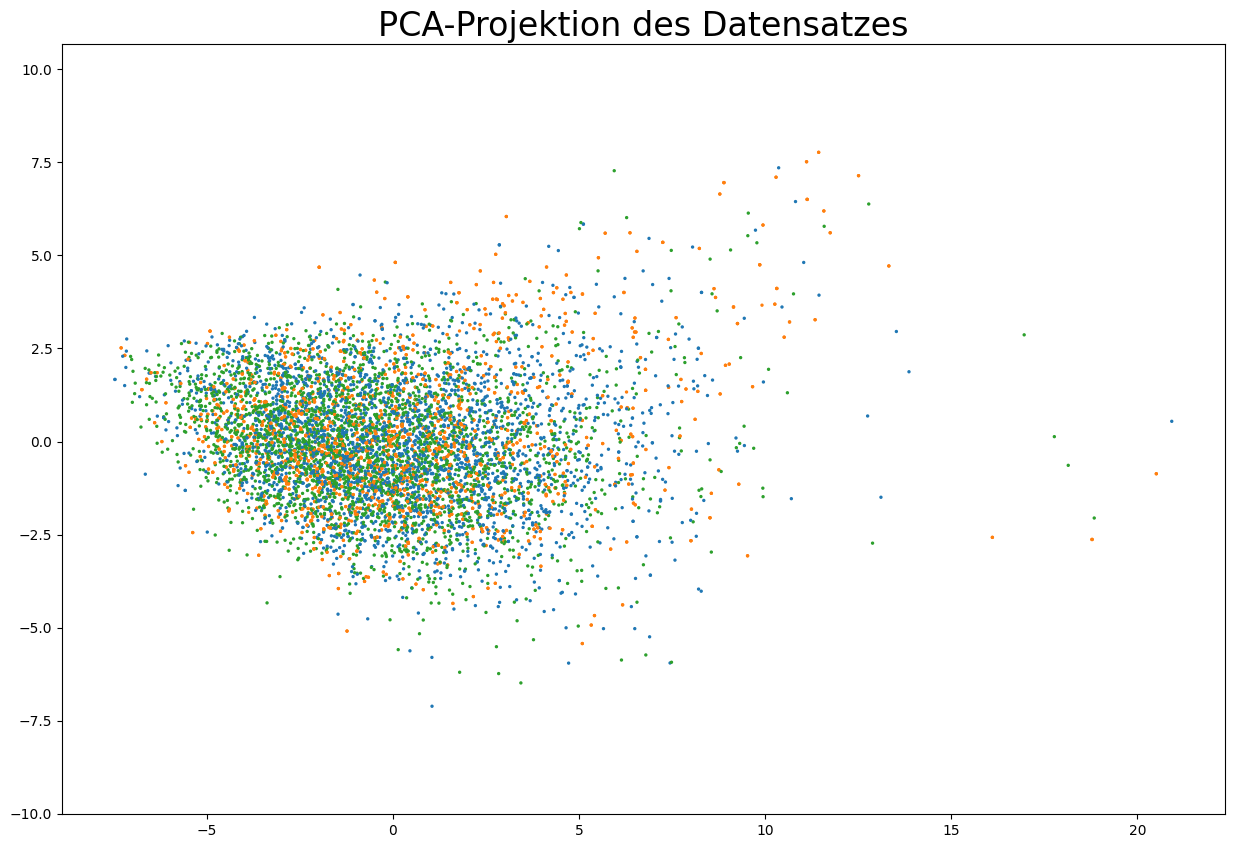

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

ds = torch.load("data/dataset_mr_after_first_layer/Trainset_complete.pt")

# Daten für PCA extrahieren
input_data = [item['input'].tolist() for item in ds]
targets_data = [item['targets'] for item in ds]


reducer = PCA(n_components=2)
embedding = reducer.fit_transform(input_data)

# Scatterplot erstellen
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[torch.argmax(x)] for x in targets_data],
    s=2)
ax.set_ylim(auto=True)
ax.set_xlim(auto=True)
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA-Projektion des Datensatzes', fontsize=24)
plt.show()

### 3.2.2 Gesamter vs. geteilter Datensatz

Die erste und wichtigste Erkenntnis ist, dass die Trainingskurve deutlich abgeflacht ist, wenn man die Trainingsstrategie verfolgt, die wir unsprünglich angedacht hatten, sprich 6 Trainingsdatensätze nacheinander rundum für je eine Epoche nutzen. Nachdem wir die Hardware-Limitation durch das Speichern der Zwischenergebnise gelöst hatten, konnten wir problemlos auf dem gesamten Datensatz trainieren. Auch konnten wir später beim richtigen Training des gesamten Netzes feststellen, dass die Hardware-Limitation primär durch die Batchsize entsteht und nicht durch die größe des initialen Datensatzes.

Der folgenden Grafik kann man entnehmen, dass das Training auf dem gesamten Datensatz deutlich schneller konvergiert als, die geteilte Variante.

Zu sehen ist:
* in orange: Training mit 6 Trainingsdatensätzen
* in blau: Training mit einem Trainingsdatensatz

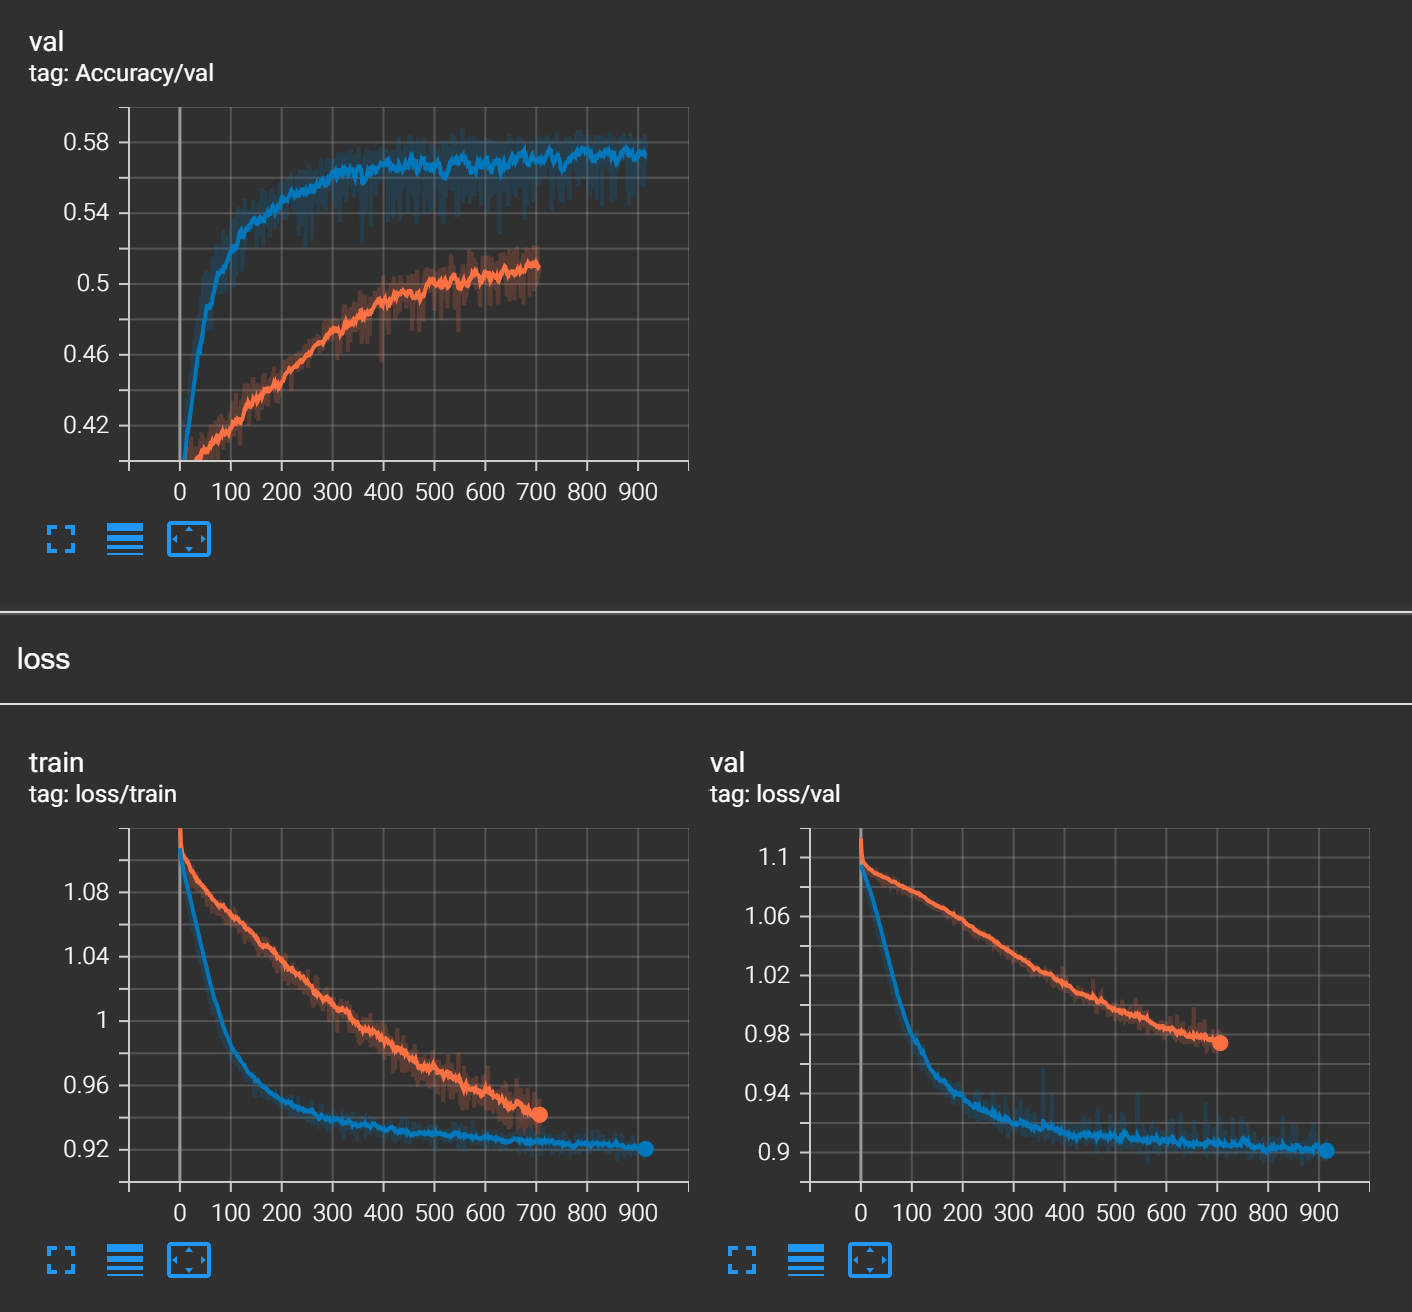

### 3.2.3 Optimizer: SGD

Bei der Anpassung der Parameter eines Neuronalen Netzes basierend auf den Gradienten gibt es verschiedene Anpassungsstrategien. Die üblichen Optimierungsarten sind SGD und ADAM. SGD steht für Statistical Gradient Descent. Bei dieser Methode ist eine feste Lernrate sowie ein Momentum definiert.

Die Lernrate wird mit dem Gradienten multipliziert, bevor dieser von dem jeweiligen Parameter zur Optimierung abgezogen wird. Kleinere Lernraten sollen verhindern, dass beim Optimieren der Parameter über das Optimum gesprungen wird.

Das Momentum definiert einen Anteil, zudem der Gradient aus dem vorherigen Schritt in den neuen Gradienten eingerechnet werden. Ein höheres Momentum hat zur Folge, dass bei vielen Richtungswecheln der Gradienten die Optimierungsrate verringert wird und einem mittleren Trend folgt. Folgen alle Gradienten einer ähnlichen Richtung, wird die Optimierungsrate mit höherem Momentum gesteigert. Dies soll bewirken, dass die Optimierung weniger stark von lokalen Minima beeinflusst wird, sondern dem allgemeinen Trend folgt und möglichst ein globales Minimum erreicht.

Im Standardfall wird für jedes Sample der Gradient berechnet. Wir nutzen hier Mini-Batch Gradient Descent. Dies erfolgt nach dem gleichen Prinzip nur, dass die Gradienten durch den Forward Pass einer gesamten Batch berechnet werden. [6]

Eine Steigerung der Lernrate hat bei unserem Modell wie auch allgemein zu erwarten ist, bewirkt, dass das Training schneller abläuft aber auch instabiler wird. In der folgenden Grafik sind 3 Trainingsdurchläufe zu sehen, bei denen wir die Lernrate je um eine zehnerpotenz gesteigert haben:

* dunkelblau: lr = 0.003
* rot: lr = 0.03
* grau: lr = 0.3 (nicht in Grafik abbildbar)

Wie zu erwarten führt eine Steigerung der Lernrate von 0.003 um das zehnfache zu einer stärkeren Steigung, was einem schnelleren Training entspricht. Allerdings ist der Validation-Loss und die Accurary deutlich instabiler. Bei einer Lernrate von 0.3 ist das Training nach wenigen Epochen abgebrochen, weil das Loss zu groß wurde. Die intuitive Erklärung dafür ist, dass das Parameter-Setting in der Loss-Landscape in immer größeren Schritten über das Optimum "hinwegspringt".

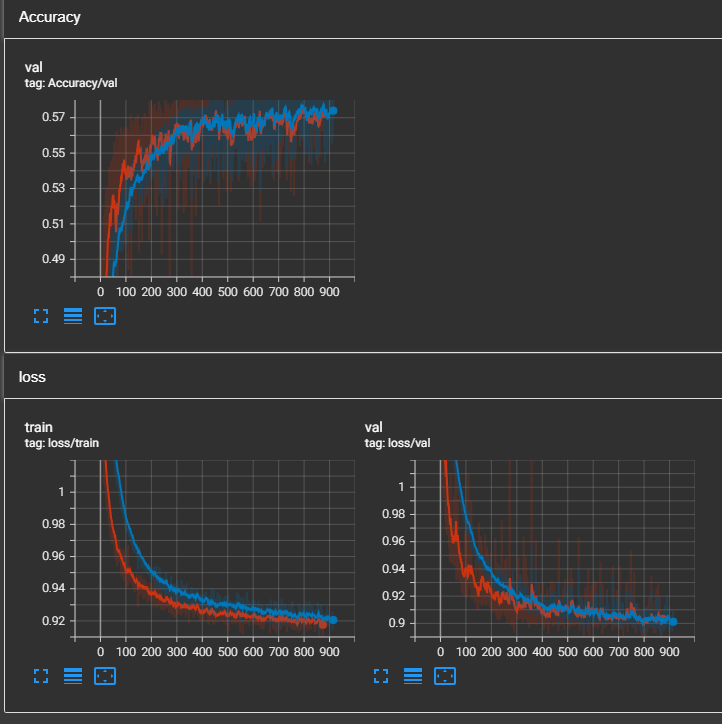

Außerdem haben wir die Wirkung des Momentums beim SGD-Optimizer ausprobiert. Folgende Stufen haben wir ausprobiert:

* rot: mom = 0.01
* orange: mom = 0.3
* hellblau: mom = 0.5

Man sieht in der folgenden Grafik, dass das Momentum in diesem Fall keinen besonderen Einfluss auf das Trainingsverhalten hat. Man kann bei starker Glättung der Kurven, was hier erfolgt ist, erkennen, dass ein geringeres Momentum eine etwas instabilere Kurve verursacht. Vorerst können wir dies jedoch vernachlässigen.

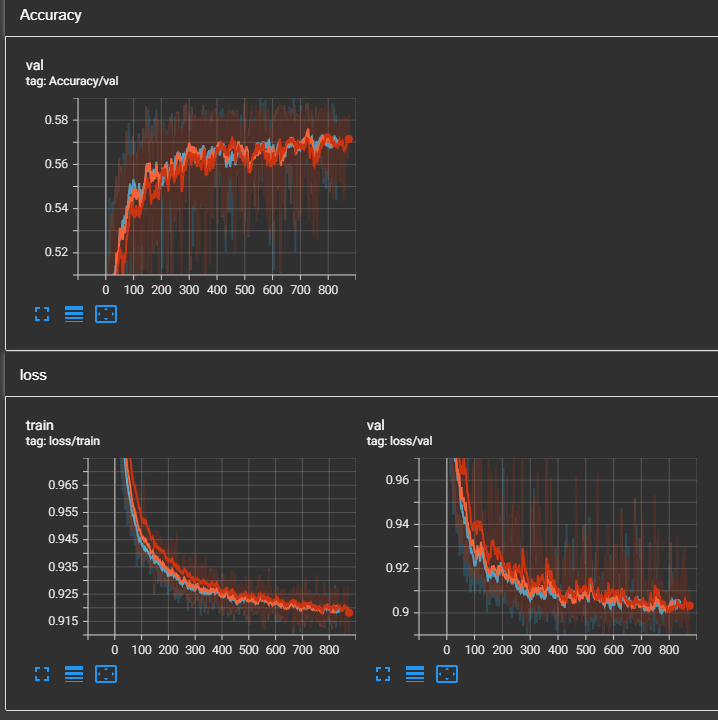

### 3.2.4: Optimizer: ADAM

Der ADAM Optimizer (Adaptive Momentum Estimation) ist ein Algorithmus zur Berechnung der Optimierungsrate auf Basis des exponentiellen gleitenden Durchschnitten der Gradienten und der Gradienten Quadrate. Der gleitende exponentielle gleitende Durchschnitt der Gradienten ist die Anwendung von Momentum. Der exp. gleit. Durchschnitt der Gradienten Quadrate soll zusätzlich stark vom allgemeinen Trend abweichende Gradienten unterdrücken. [7] ADAM ist in der Machine Learning-Community einer der gänigsten Optimizer.

Auch in unserem Anwedungsfall zeigt sich, dass die Lernkurve mit ADAM (im Folgenden in grün zu sehen) am steilsten und am stabilsten ist. Daher haben wir ihn bei den folgenden Versuchen zur Modellarchitekur als Standard genutzt.

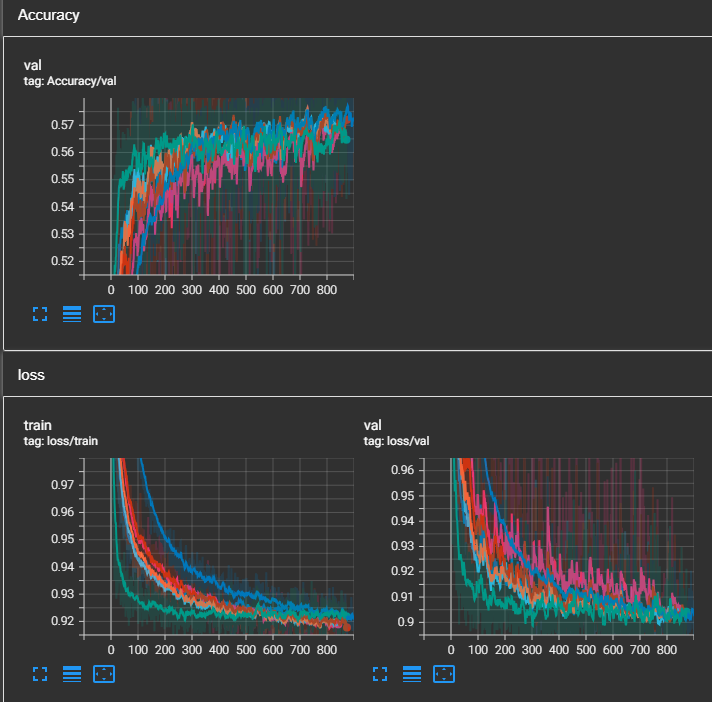

### 3.2.5 Batchsize

Als letztes blieb der Parameter Trainingsbatchsize. Dieser Parameter bestimmt, wieviele Samples in einer Batch berechnet und gemeinsam in einem Gradienten-Schritt verarbeitet werden. Wir haben folgen Einstellungen ausprobiert:

* dunkel-blau: bs = 50
* hell-blau: bs = 100
* pink: bs = 250

Da die Kurvenverläufe nicht stark variieren möchten wir hier primär auf einen ökonomischen Aspekt eingehen. In der unten abgebildeten Grafik sind die Grafen an der X-Achse nicht wie oben anhand der Epoche abgetragen, sondern anhand der Trainingszeit. Alle drei Versuche wurden etwa für 800 Epochen auf einer GPU bei Google Colab durchgeführt. Man kann deutlich erkennen, dass eine Batchsize von 50 ineffizient zu sein scheint und nicht die volle Kapazität der GPU zur Parallelsierung ausnutzt. Mit einer Batchsize von 100 oder 250 kann mit dem Training in kürzerer Zeit ein größerer Teil des Datensatzes abgedeckt werden. Wir haben uns für das weiter Vorgehen für einer Batchsize von 100 entschieden. Beim späteren Training mit dem vollen Netz müssen wir die Batchsize jedoch auf 45 reduzieren, was das auf dem genutzten Quadriga Server der FH Wedel bereits den gesamten GPU-RAM inanspruch nimmt.

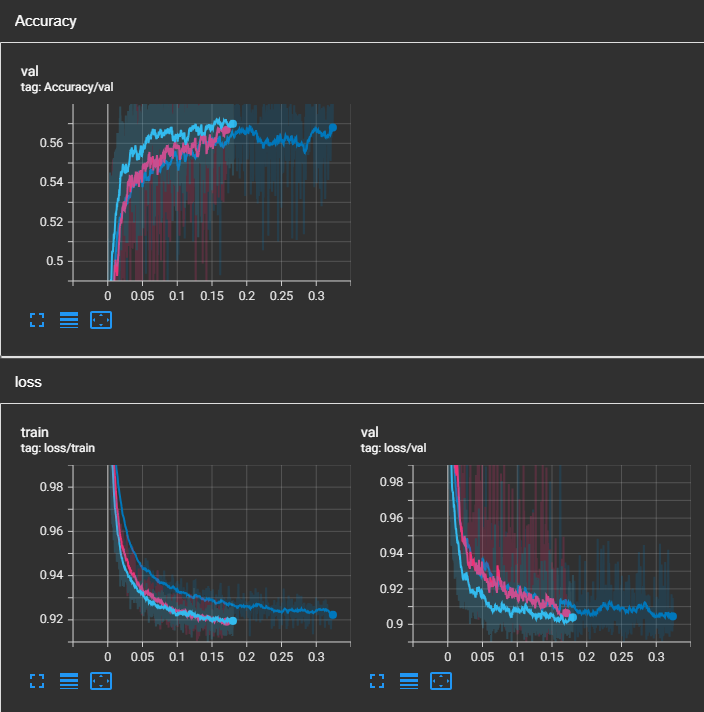

## 3.3 Optimierung Modellarchitektur

Nachdem wir ein zufriedenstellendes Trainingshyperparametersetting festgelegt hatten, haben wir als nächsten die Modellarchitektur des Klassifizierers nach dem BERT-Layer soweit es geht optimiert. Denn bei den verschiedenen Hyperparametersetting kann man erkennen, dass die resultierende Performance durch die Hyperparameter nicht verbessert wurde. Daher haben wir zunächst weiterhin auf den Output-Daten des BERT-Layer mehrere uns bekannte Architekturen ausprobiert.

Unsere Idee war durch das Einbauen von z.b. Residual Layern das Netz tiefer zu machen und dadurch mehr Komplexität abbilden zu können. Sowohl mit allen Ansätzen ist es jedoch zum Overfitting gekommen. Auch unter Anwendung von Batch-Normalisation in Kombination mit Layer-Normalisation hat sich dies kaum verbessert.

In der folgenden Grafik sind die Trainingsverläufe zu den entsprechenden Architekturen abgebildet:
- grün: 2 fully-conntected Layer mit Batchnormalization (BN) und Layernormalization (LN)
- hellblau: 1 residual Layer mit BN und LN
- rot: 2 residual Layer mit BN und LN
- orange: 2 residual Layer nur mit BN
- pink: 1 Bottleneck Layer mit BN und LN

Der Bottleneck Layer und Layernormalization werden im folgenden außerdem kurz erläutert, weil diese bisher nicht beschrieben wurden.

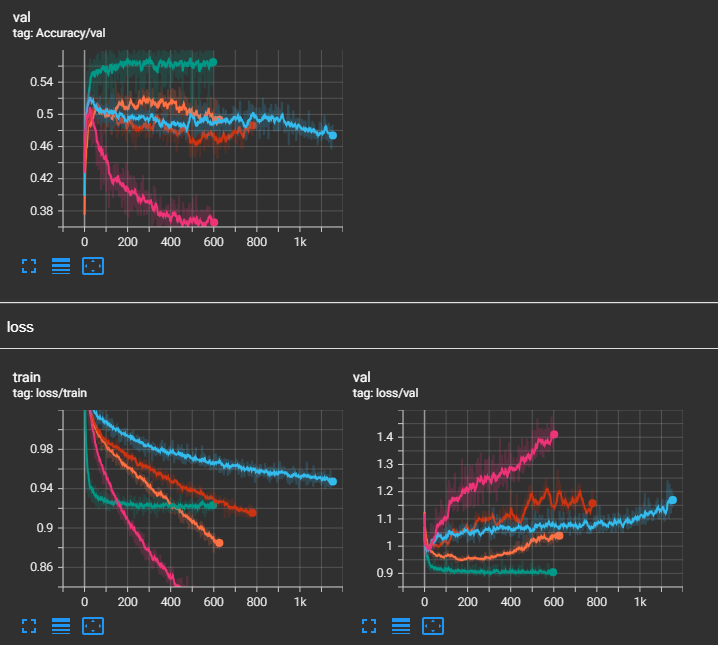

### 3.3.1 Layer Normalization

Basierend auf der Idee der Batch Normalization wurde die Layer Normalization entwickelt, da Batchnormalization nicht in Recurrenten Neuronalen Netzen genutzt werden kann. Dabei werden genau wie bei der Batch Normalization die Aktivierungen normalisiert. Jedoch nicht von dem selben Knoten über mehrere Samples hinweg, sondern bei einem Sample über alle Knoten eines Layers. [8]

### 3.3.2 Bottleneck Layer

Ein Bottleneck Layer ist ein Residual Layer bei dem mindestens 2 fully connteced Layer hintereinander geschaltet sind, bevor die Input-Werte wieder. Die Idee dazu stammt aus dem GoogLeNet für Bildverarbeitung, bei dem in Bottleneck Layern alle Channels über eine 1x1 Faltung auf einen Channel reduziert werden. [9]

## 3. Fine Tuning Gesamtmodell


Nachdem wir eine hinreichend gute Modell-Architektur ermittelt haben, haben wir diese Architektur in einem vollständigen Modell mit dem vortrainierten BERT-Layer als ersten Layer trainiert. Als erstes haben wir dazu den ersten Layer beim Training eingefrohren und zunächst nur die Parameter des Klassifizierungsnetzwerkes trainiert. Der Trainingsverlauf ist im folgenden zusehen. Außerdem auch die Modellbewertung anhand des Testsets mit den Metriken, die wir bereits im Notebook zu den klassischen Verfahren vorgestellt haben.

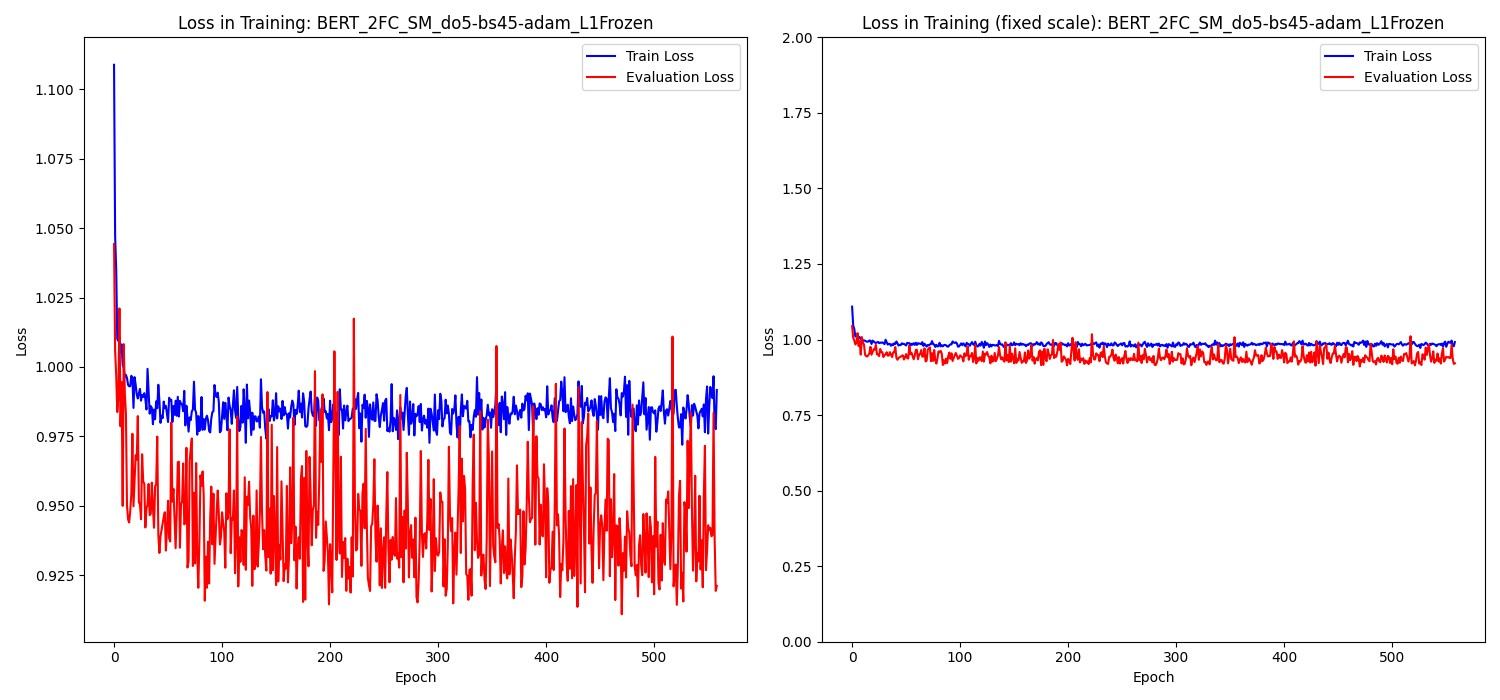

[MAIN]: Loading criterion
Test-Loss: 0.9046308994293213


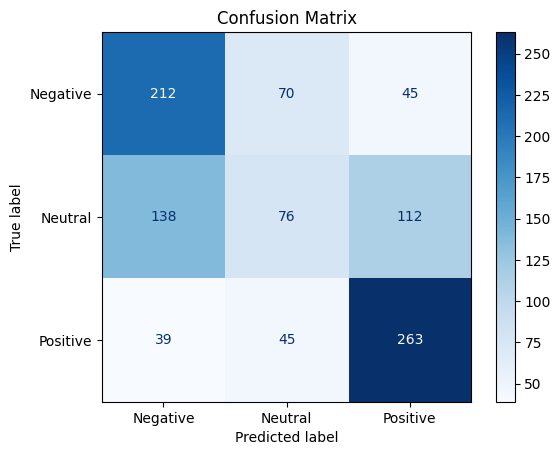

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.65      0.59       327
     Neutral       0.40      0.23      0.29       326
    Positive       0.63      0.76      0.69       347

    accuracy                           0.55      1000
   macro avg       0.52      0.55      0.52      1000
weighted avg       0.53      0.55      0.53      1000



0.551

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_mr/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_SM_do5-bs45-adam_L1Frozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

Anschließend haben wir erneut versucht, dieses Modell weiter zu optimieren, weil das Ergebnis 53% Accuracy noch nicht sehr befriedigend war. Wir hatten überlegt, dass es eventuell zu weniger starkem Overfitting kommt, wenn der Klassifizierungslayer bereits trainiert ist und wir das Gesamtmodell danach weiter optimieren. Unsere These stelle sich als falsch heraus. Wie man auf dem folgendem Chart deutlich sehen kann, kam es auch hier bereits nach einer Epoche zum Overfitting.

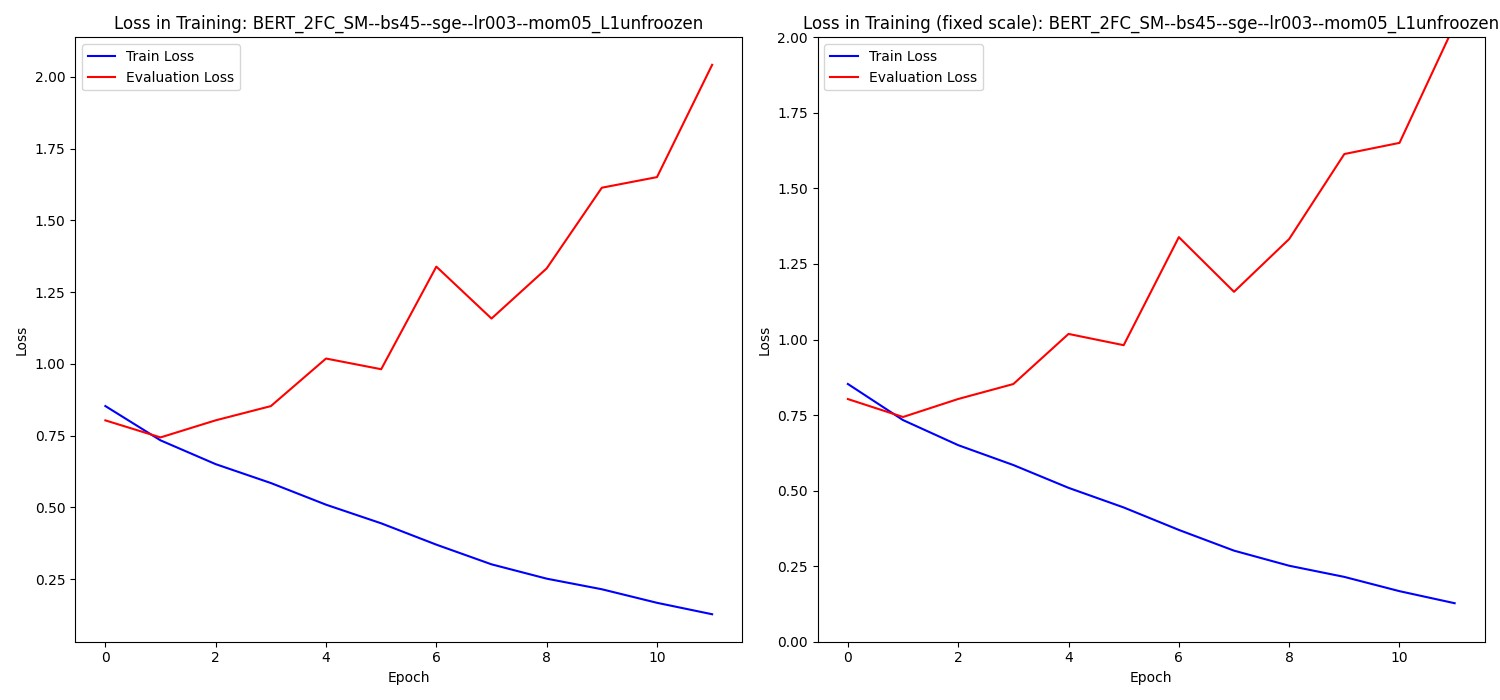

Man sieht aber auch, dass sich das Modell in der ersten Epoche noch verbessert. Daher haben wir eine unorthodoxe Technik, das early Stopping, angewendet, um trotzdem ein besseres Modell zu erhalten. Wir haben die Learning Rate herabgesetzt auf 0.0003, haben das Training live überwacht und in dem Moment gestoppt, wo wir das Optimum vermutet haben. So konnten wir die Accuracy auf 62% verbessern.

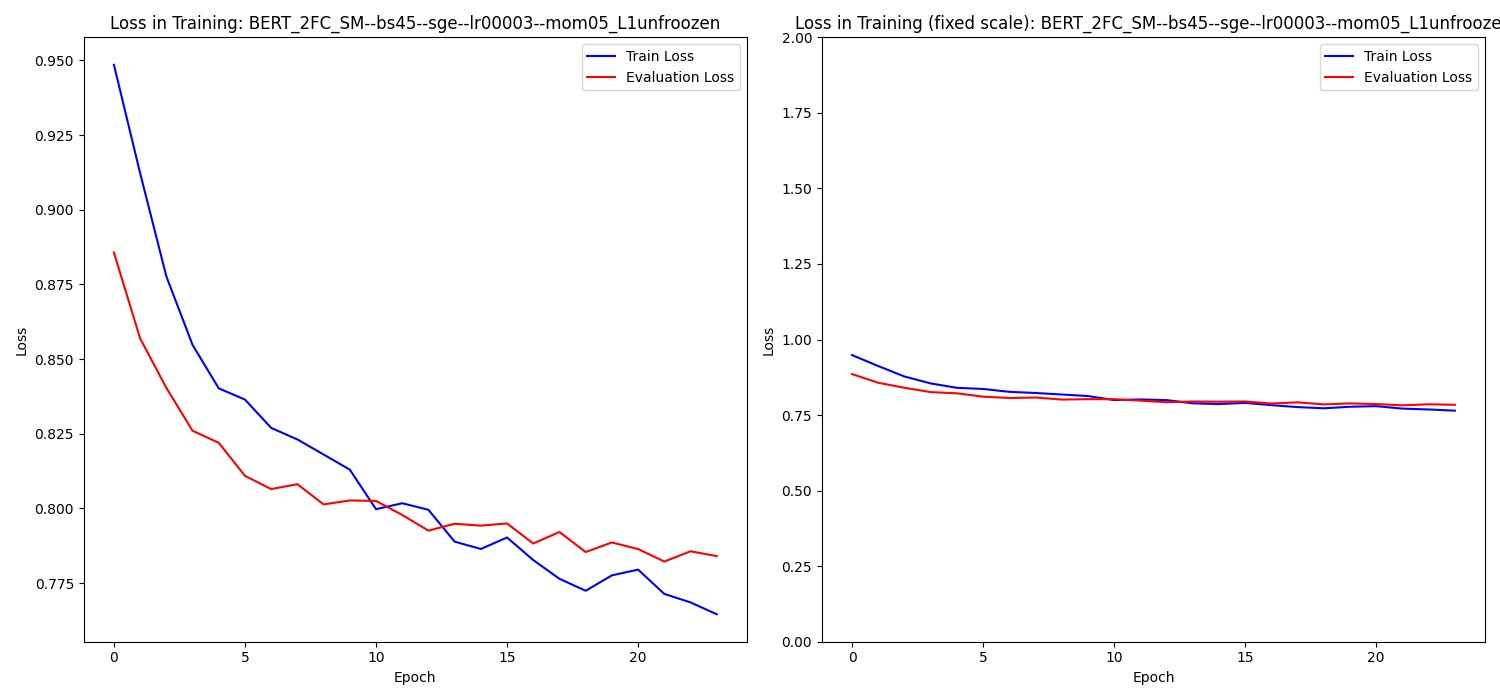

[MAIN]: Loading criterion
Test-Loss: 0.7623834013938904


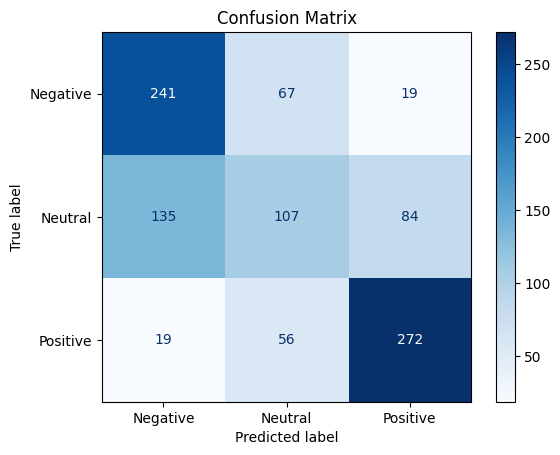

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.61      0.74      0.67       327
     Neutral       0.47      0.33      0.38       326
    Positive       0.73      0.78      0.75       347

    accuracy                           0.62      1000
   macro avg       0.60      0.62      0.60      1000
weighted avg       0.60      0.62      0.61      1000



0.62

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_mr/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_SM--bs45--sge--lr00003--mom05_L1unfroozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

## 3.4 Twitter Datensatz

Da wir eine Vielzahl an Hyperparameterkombinationen und Modellarchitekturen für das Training mt dem Movie Review Datensatz ausprobiert haben, sind wir zu dem Schluss gekommen, dass das Modell schlicht zu tief ist bzw. der Datensatz zu klein ist, um ein gesamtes BERT-Modell sinnvoll zu trainieren. Daher haben wir uns von dem Training auf dem deutlich größeren Tweetsdatensatz eine deutlich bessere Performance erwartet und auch, dass das es nicht zum Overfitting kommt, auch wenn man alle Parameter trainiert. Wir haben beide Varianten, BERT-Layer mit- und nicht mittrainieren, ausprobiert. Ein Verlaufs-Chart von den Trainings ist hier nicht sinnvoll, da selbst nach 48h Training nur sehr wenige Epochen durchgeführt wurden und damit auch kein sinnvoller Verlauf aufgezeichnet wurde. Das erste Modell, bei dem der erste Layer nicht optimiert wurde, hat 7 Epochen geschafft. Das zweite Modell, bei dem alle Parameter trainiert wurden, hat knapp 2 Epochen geschafft.

Im Folgenden sind die Auswertungen auf dem Testset zu sehen (hier auf Grund von Hardware-Limitierungen nur mit den ersten 1000 Samples). Enttäuschender Weise hat keines der beiden Modelle es geschafft die Daten sinnvoll zu klassifizieren. Es folgte eine langwierige Suche nach der Ursache, da wir zunächst ein Fehler in unserer Programmierung vermuteten. Zur Fehlersuche haben wir zunächst das Trainingsverhalten mit einer kleinen Stichprobe von 100 Samplen untersucht. Unter anderem haben wir uns dazu auch die Confussion-Matrix pro Epoch in unserem Logger aufgezeichnet.  

### 3.4.1 Modell 1 (BERT-Layer nicht optimiert)

#### 3.4.1.1 Evaluation Testdatensatz

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_tw__BERT_2FC_do5_SM--bs45--adam_1froozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)

[MAIN]: Loading criterion


Test-Loss: 142.42771911621094


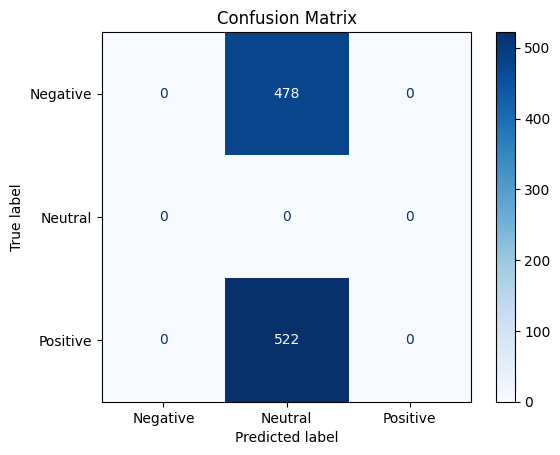

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     478.0
     Neutral       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00     522.0

    accuracy                           0.00    1000.0
   macro avg       0.00      0.00      0.00    1000.0
weighted avg       0.00      0.00      0.00    1000.0



0.0

In [ ]:
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

#### 3.4.1.2 Evaluation Trainingsdatensatz 1

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Trainset_1.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_tw__BERT_2FC_do5_SM--bs45--adam_1froozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)

[MAIN]: Loading criterion


Test-Loss: 142.53138732910156


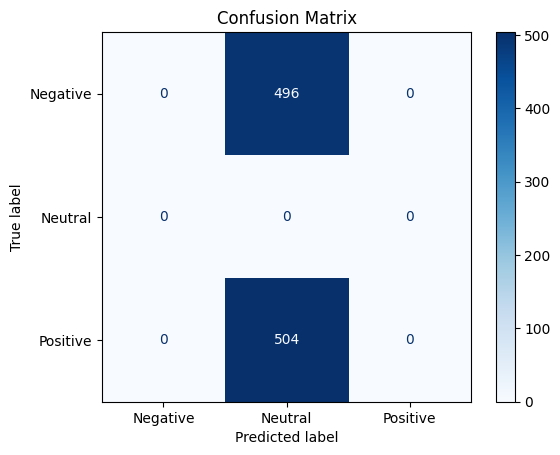

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     496.0
     Neutral       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00     504.0

    accuracy                           0.00    1000.0
   macro avg       0.00      0.00      0.00    1000.0
weighted avg       0.00      0.00      0.00    1000.0



0.0

In [ ]:
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

### 3.4.2 Modell 2 (BERT-Layer optimiert)

#### 3.4.2.1 Evaluation Testdatensatz

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_do5_SM--bs45--adam--tw.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)

[MAIN]: Loading criterion


Test-Loss: 34.64246368408203


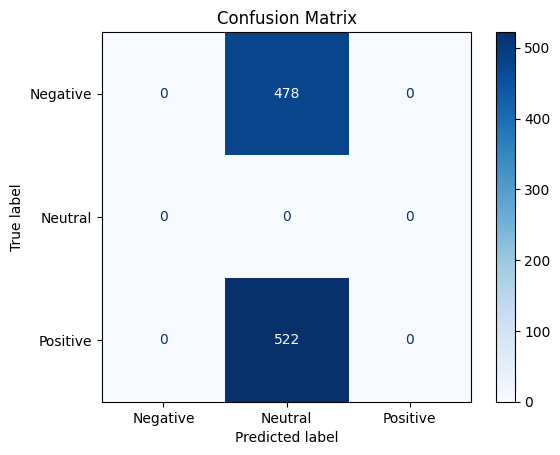

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     478.0
     Neutral       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00     522.0

    accuracy                           0.00    1000.0
   macro avg       0.00      0.00      0.00    1000.0
weighted avg       0.00      0.00      0.00    1000.0



0.0

In [ ]:
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

#### 3.4.2.2 Evaluation Trainingsdatensatz 1

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Trainset_1.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_do5_SM--bs45--adam--tw.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)

[MAIN]: Loading criterion


Test-Loss: 34.65203857421875


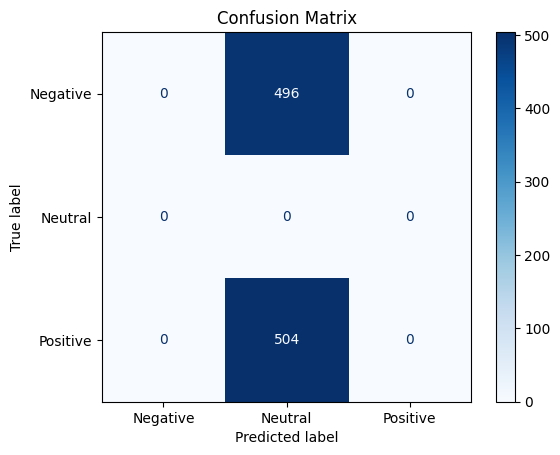

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     496.0
     Neutral       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00     504.0

    accuracy                           0.00    1000.0
   macro avg       0.00      0.00      0.00    1000.0
weighted avg       0.00      0.00      0.00    1000.0



0.0

In [ ]:
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

### 3.4.3 Optimierung Trainingsparameter

Es ist auffällig, dass die Evaluation bei beiden Modellen bei beiden Datensätzen zeigt, dass alle Samples einer Klasse zuordnet i. Um dieses Problem zu lösen wollten wir zunächst das Modell zum Overfitting zu bringen, da man von dort aus mit Regularisierungstechniken das Training anpassen kann. Wenn man nicht in der Lage ist, ein Overfitting herbeizuführen, kann auch kein Lernprozess stattfinden. Daher haben wir zunächst einige händische Versuche mit einer Sample-Größe von 10 gemacht. Wir haben es zuerst mit dem gut bewährten ADAM-Optimizer probiert. Dabei ist uns aufgefallen, dass die Accuracy immer zwischen zwei bestimmten Werten gesprungen ist, wie in dem Beispiel auf dem folgenden Chart.

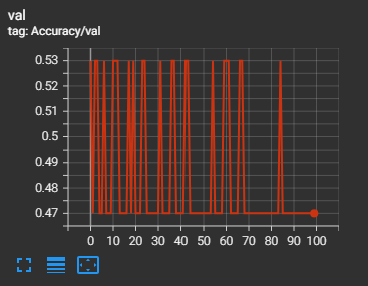

Zusätzlich haben wir in unserer Logger-Klasse ein funktion hinzugefügt, die der Evaluation am Ende einer jeden Epoch neben der Berechnung der Accuracy auch die Confussion Matrix aufzeichnet. Dadurch konnten wir beobachten, dass der Klassifizierer hier alle Samples einer Klasse zuordnet, diese Zuordnung aber mehrfach wechselt (wie im Folgenden zwischen Schritt 3 und 4).

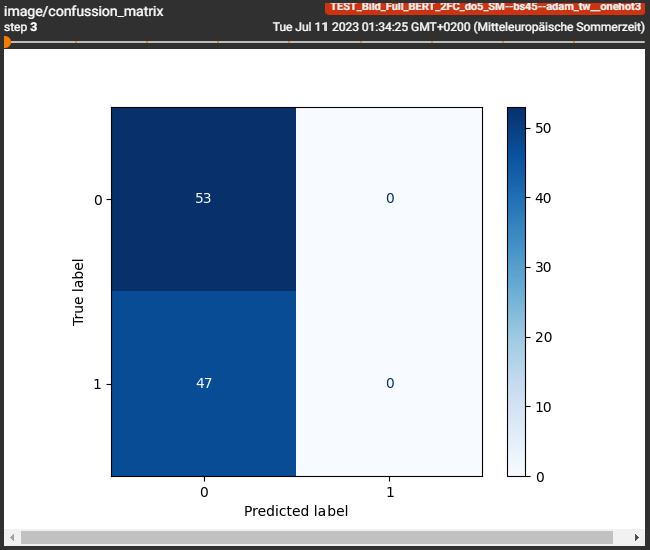

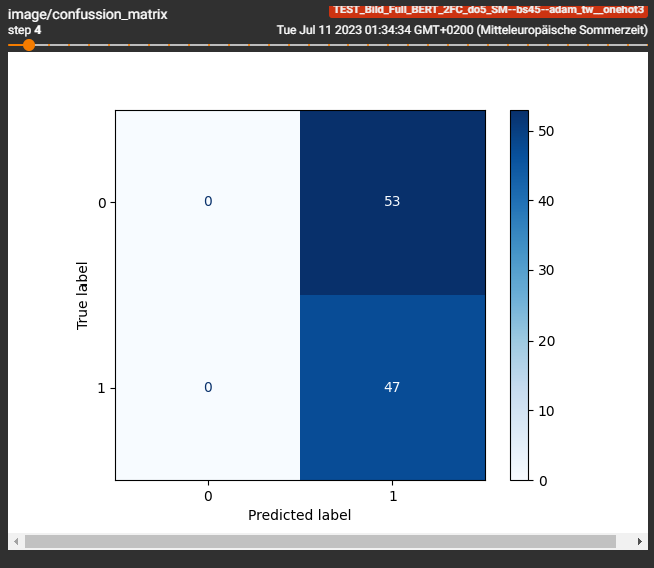

Nach einigem Rumprobieren mit dem SGD-Optimizer haben wir den richtigen Mix aus Learning Rate, Momentum und Datenencoding gefunden. In der ersten der folgenden Abbildungen sieht man zwei Kurvenpaare. Die organgene und graue Linie haben jeweils eine Learing Rate von 0.03 und ein Momentum von 0.1. Bei der Grauen sind die Targets in zwei, bei der Orangenen in drei Klassen codiert (Klasse 0 ist dann immer leer). Die pinke und die grüne Linie haben jeweils eine Learning Rate von 0.003 und ein Momentum von 0.2. Da sich die Zuordnung der Samples bei zu letzt genannten Kombination kaum bis garnicht verändert, zu sehen an der konstanten Accuracy, scheint dieses Setting zumindest für unseren Zeithorizont zu langsam zu sein. Die erste Kombination führt jedoch schnell zu Overfitting.

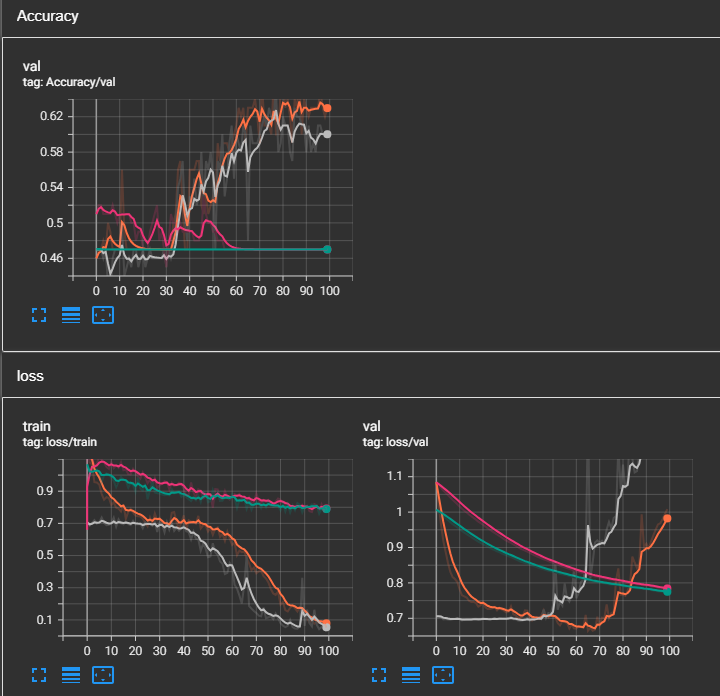

Tatsächlich ist bei diesem Versuch mit sehr begrenzter Stichprobengröße die Kombination mit 0.2 Momentum und 0.03 Learning Rate ideal. Überraschender Weise funktioniert dieses Setting nur, wenn die Targets in drei Klassen kodiert werden (hier in Dunkelblau markiert), nicht aber in 2 Klassen (Hellblau). Als Vergleich sind im folgenden Chart die rote und orangene Linie aus dem letzten Chart übernommen. Am Verlauf der dunkelblauen Kurve erkennt man gut, dass wie bei der orangenen Kurve zu nächst der Loss sinkt, ohne dass sich die Accuracy steigert und der Loss zurzeitig ein Plato erreicht. Da das Momentum bei Dunkelblau höher ist, dauert dieses länger an. Dafür sinkt nach dem Plato nicht nur das Trainings-Loss sondern auch der Validation-Loss, im Gegensatz zum Trainingsverlauf mit 0.1 Momentum in Organge.

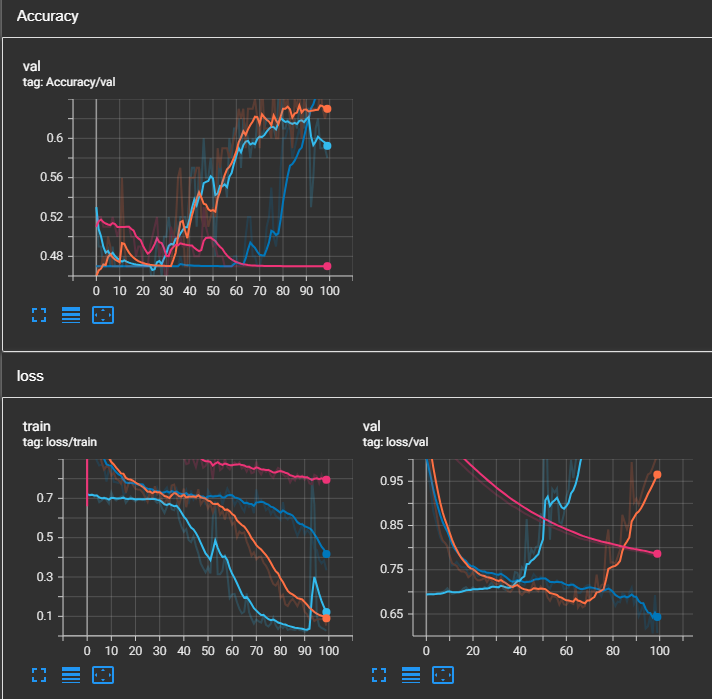

Leider hat ließen sich der Erfolg mit diesen Hypertrainingsparametern nicht auf das Training mit einem größeren Datensatz übertragen. Nach 62h und 29 Epochen Training stellte sich heraus, dass es auch mit diesem Hyperparametersetting zum Overfitting kommt. Trotzdem schafft das Modell auf den Testdaten eine Accuracy von 83%.

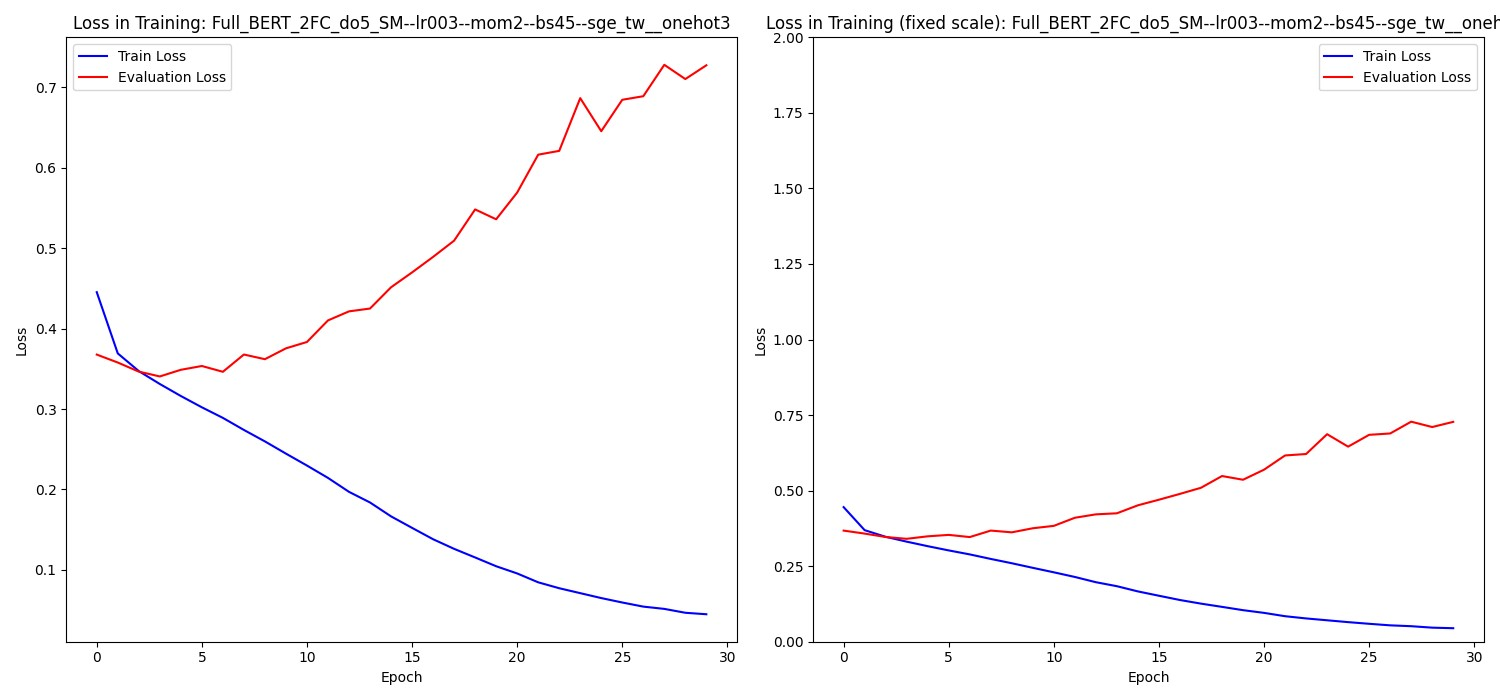

In [5]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Trainset_1.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_Full_BERT_2FC_do5_SM--lr003--mom2--bs45--sge_tw__onehot3.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)

[MAIN]: Loading criterion


Test-Loss: 1.6541162729263306


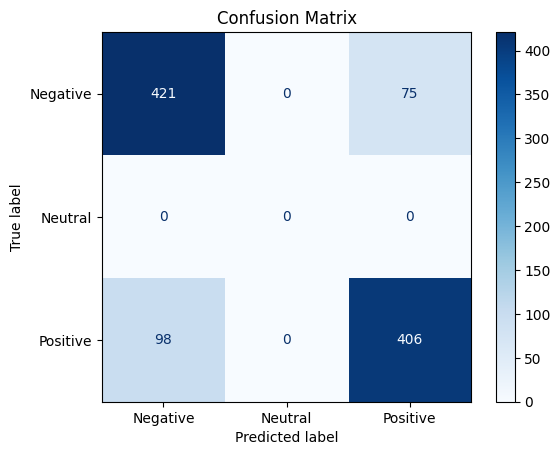

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83       496
    Positive       0.84      0.81      0.82       504

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



0.827

In [6]:
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

## 3.5 Kreuztest

Abschließend haben wir uns wie auch bei den klassischen Modellen für die jeweils besten Modell angeguckt, wie die Performance auf dem jeweils anderen Datensatz ist.

Absolut performt das Twitter-Modell in diesem Vergleich besser. Relativ zur vorherigen Performance haben sich allerdings beide Modelle um ca. 40 % verschlechtert.

### 3.5.1 Movie-Modell auf Twitter-Daten
Dazu haben wir zunächst das Modell, dass mit Early-Stopping auf den Movie Review Daten trainiert wurde, mit dem Tweets-Datensatz evaluiert. Die Accuracy ist mit 0.38 nicht besonders hoch. Vergleichen mit der Accuracy auf den 'eigenen' Test-Daten sind das 0.24 bzw. 39 % unterschied. Sowohl für das positive, als auch für das negative Label ist die Precision mit 0.86 und 0.89 relativ hoch, der Recall mit unter 0.5 hingegeben relativ gering. Dies bedeutet, dass die relevanten Predictions, zu denen es ein Label in den Daten gibt, relativ sicher sind. Jedoch eine Menge an Daten, dem neutralen Label zugeordnet werden. Dazu gibt es zwei Erklärungsmöglichkeiten:

1. Die Einschätzung des Sentiments durch das Modell ist korrekt. Das Sentiment ist allerdings so schwach positiv oder negativ, dass es im Movie Review Datensatz als neutral eingestuft würde.
2. Die Samples die falsch zugeordnet wurden befinden sich, bedingt durch die unterschiedlichen Domänen und Kontexte der Kommentare, in einem Raum, der durch das Modell nicht gesampelt wurde.

[MAIN]: Loading criterion
Test-Loss: 1.1993179321289062


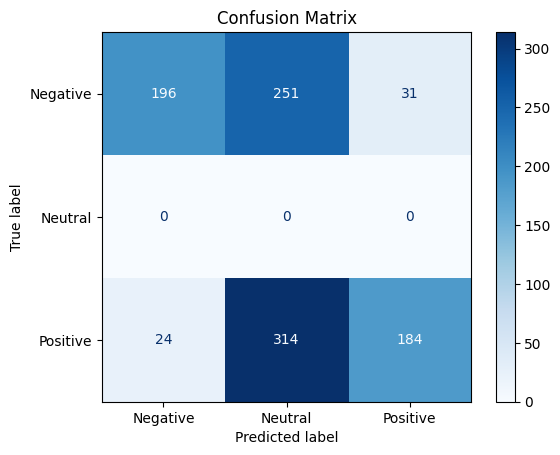

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.89      0.41      0.56       478
     Neutral       0.00      0.00      0.00         0
    Positive       0.86      0.35      0.50       522

    accuracy                           0.38      1000
   macro avg       0.58      0.25      0.35      1000
weighted avg       0.87      0.38      0.53      1000



0.38

In [ ]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_tw/Testset.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_BERT_2FC_SM--bs45--sge--lr00003--mom05_L1unfroozen.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

Um einzuschätzen zu können, ob der geringe Recall durch das Modell oder die unterschiedlichen Labels zustande kommt, haben wir im folgenden ein paar Samples aus dem Testdatensatz mit Targets und Predictions ausgegeben. Bei einem Blick auf die false neutralen im Vergleich zu den richtig negativen Samples kann man jedoch keinen systematischen Unterschied erkennen. Es scheint also eher Erklärungsansatz 2 zuzutreffen.

In [ ]:
test_data = pd.read_csv(path_test, delimiter=";")
test_data = test_data.iloc[:1000].reset_index(drop=True)
outputs = pd.Series(outputs)

df = pd.concat([test_data['Phrase'],test_data['Sentiment'], outputs], axis=1)
df.rename(columns = {'Sentiment':'Target', 0:'Prediction'}, inplace = True)
df['Prediction'] = df['Prediction'] -1
df.loc[df['Target']==-1].loc[df['Prediction'] <= 0].head(20)

Phrase  Target  Prediction
0   @CorneliaArcher OOC Argh. I feel your pain alr...      -1           0
3   @mellon__ i thought it was ï¿½150 a month and ...      -1           0
5   ugh need to catch up with SYTYCD.  Results Sho...      -1          -1
6   im gutted im in for the night  i want some eye...      -1          -1
7   @aarondotjpeg I heard about the 2 hour homeles...      -1           0
8   @abbigshmail The same thing happened to me! It...      -1           0
9   @Imagin_that Irish language is almost dead I'm...      -1           0
16  @Modelmad grim and overcast here Phil and rain...      -1           0
17  The worst thing in Plants that you are doing L...      -1           0
20  @MrPoofyPJPants I always get headaches, never ...      -1          -1
21  @Jemfyr Oh my goodness!! My little green flowe...      -1           0
23  Anyone understood the #iPhone T-Mobile Contrac...      -1          -1
26  I think i'm getting the hang of this... why am...      -1          -1
27  Ð¡Ð¸Ð¶Ñ Ð² ÑÐµÑ
Ñ, Ð½Ð° MTS G3 Ð¼Ð¾Ð´ÐµÐ¼Ðµ...      -1           0
28  My car is back from the body shop, and it look...      -1          -1
29           My internet is down  http://bit.ly/4pDQQ      -1           0
32  Time to pick the dragon upï¼?I'm sure she'll h...      -1           0
34  @passingcarss i wont have time to buy  and i n...      -1           0
40                                      Cannot sleep       -1           0
42                                           3 short       -1           0

### 3.5.2 Twitter-Modell auf Movie-Daten

Als zweites haben wir andersrum das Modell, das auf den Twitterdaten trainiert wurde, auf dem Testdatensatz für die Movie-Reviews testet. Im Ergebnis hat diese Kombination eine Accuracy von 0.49, was im Vergleich zum 'eigenen' Testdatensatz 0.34 bzw 40 % Unterschied sind. Im Gegensatz zu der ersten Kombination ist hier die Precision deutlich kleiner mit um die 0.5, der Recall mit 0.68 und 0.82 allerdings deutlich höher. Der Grund für die Deskrepanz bei Recall und Precision zwischen den beiden Modellen ist offensichtlich nicht in der Performance begründet. Da die Precision ausdrückt, wie hoch der Anteil korrekt zugeordneter Samples pro Klasse ist, muss dieser Wert bei diesem Modell geringer sein, da es neutrale Samples gibt, die unabhängig von der Zuordnung die Precision veringern, da sie in keine der beiden Klassen gehören. Der Recall dagegen ist hoch, wenn wenige Samples einer Klasse fälschlicher weise dieser nicht zugeordnet wurde. Dieser Wert ist hier deutlich höher, als in der ersten Kombination, da es kein neutrales Label gibt, worunter grenzwertig positive oder negative Phrasen fallen könnten. Aus diesem Grund ist es sinnvoll diesen Test erneut ohne neutrale Samples zu wiederholen.

[MAIN]: Loading criterion
Test-Loss: 5.792423248291016


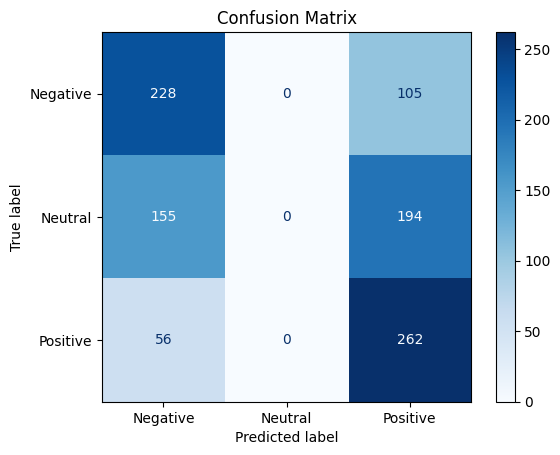

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.52      0.68      0.59       333
     Neutral       0.00      0.00      0.00       349
    Positive       0.47      0.82      0.60       318

    accuracy                           0.49      1000
   macro avg       0.33      0.50      0.40      1000
weighted avg       0.32      0.49      0.39      1000



0.49

In [7]:
dataholder = load_json("params_bert_test.json")
path_test = "data/dataset_mr/Trainset_1.csv"
target_labels = ["negative", "neutral", "positive"]
model_path = "final_model_Full_BERT_2FC_do5_SM--lr003--mom2--bs45--sge_tw__onehot3.pt"
outputs, targets, test_loss = test_bert(dataholder, path_test, model_path)
test_statistics(outputs, targets, target_indices=[0,1,2], test_loss=test_loss)

# 4. Fazit Large Language Model



## 4.1 Inhaltliches Fazit

In Summe hat das Twitter-Modell sowohl bei dem Test mit den eigenen Daten als auch bei dem Kreuztest mit 0.82 und 0.48 Accurary besser performt als das Movie-Modell mit 0.62 und 0.38.


## 4.2 Methodisches Fazit

- Der Adam-Optimizer ist in der Regel eine gute erste Wahl für das Training mit Neuronalen Netzen. Es kann jedoch bei Klassifizierungsnetzen das Problem auftreten, dass das Momentum durch den Adam-Algorithmus so groß ist und bleibt, dass die Klassifizierungen immer nur zwischen verschiedenen Klassen springen, sich aber nicht weiter untergliedern. Hier wird das Optimum vermutlich mehrmals übersprungen. Zeigt sich im Verglauf des Trainings ein Accurarcy, die zwischen immer gleichen Werten sprint, empfehlt es sich auf den SDG-Optimizer mit geringerer Learning Rate umzusteigen.
- Das Training eines gesamten BERT-Layers benötigt sehr viele Daten und entsprechend sehr viel Rechenkapazität. Durch die vielen Parameter kann es schnell zum Overfitting kommen, was auch mit Regularisierungstechniken nicht verhindert werden kann. Alternativ könnte man einen einzelnen Encoder-Block mit einem Attention-Layer verwenden, anstatt ein BERT-Modell, welches 12 dieser Blöcke verwendet.
- Beim Trainieren von Neuronalen Netzen ist Tensorbaord ein gutes Werkzeug um das Training zu überwachen.
- Das Vergleichen von verschiedenen Klassifizierungsmodellen funktioniert nur sehr bedingt, wenn die Modell und die entsprechenden Trainingsdaten eine unterschiedliche Anzahl an Klassen haben. Obwohl die Klassen bei uns Ordinal bis anähernt Metrisch sind hat die Vergleichbarkeit darunter gelitten. Hauptursache ist unserer Einschätzung nach, dass die eine Skala einen Mittelpunkt hat (neutral), die andere aber nicht.

# Quellen

[1] Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, 2019: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. *ArXiv* 188010.04805

[2] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob
Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz
Kaiser, and Illia Polosukhin, 2017: Attention is all
you need. *Advances in Neural Information Prcessing Systems*, pages 6000–6010.

[3] Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov, 2014: Dropout: A Simple Way to Prevent Neural Networks from Overfitting. *Journal of Machine Learning Research* 15(56):1929−1958

[4] Sergey Ioffe, Christian Szegedy, 2015: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. *arXiv* 1502.03167

[5] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, 2015: Deep Residual Learning for Image Recognition. *arXiv* 1512.03385

[6] Sebastian Ruder, 2016: An overview of gradient descent optimization
algorithms. *arXiv* 1609.04747

[7] Diederik P. Kingma, Jimmy Ba, 2017: Adam: A Method for Stochastic Optimization. *arXiv* 1412.6980

[8] Jimmy Lei Ba, Jamie Ryan Kiros, Geoffrey E. Hinton, 2016: Layer Normalization. *arXiv* 1607.06450

[9] Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich, 2014: Going Deeper with Convolutions. *arXiv* 1409.4842